# PMR tutorial on VAEs

A variational autoencoder (VAE) is a latent-variable statistical model with observable variables $\mathbf{x}$ and latents $\mathbf{z}$, where the marginal likelihood is typically written as

$$
p_{\theta}(\mathbf{x}) = \int p_{\theta}(\mathbf{x} \mid \mathbf{z}) p(\mathbf{z}) \text{d} \mathbf{z},
$$

and where the integral is generally intractable, since the generator $p_\theta(\mathbf{x} \mid \mathbf{z})$ is parametrised by a neural network, called decoder, with parameters $\theta$. Moreover, the classical EM algorithm is also intractable since neither the posterior distribution $p_\theta(\mathbf{z} \mid \mathbf{x})$ nor the computation of the lower-bound in E-step of the algorithm $\mathbb{E}_{p_{\hat \theta}(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p_{\theta}(\mathbf{x} \mid \mathbf{z}) p(\mathbf{z})}{p_{\hat \theta}(\mathbf{z} \mid \mathbf{x})}\right]$ are computationally tractable.

Instead VAEs use variational inference to optimise the statistical model $p_\theta$. We define $q_{\phi}(\mathbf{z} \mid \mathbf{x})$ to be the variational approximation of $p_\theta(\mathbf{z} \mid \mathbf{x})$ and write down the variational lower-bound for a single data-point $\mathbf{x}^i$

$$
\mathcal{L}_i(\theta, \phi) = \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log \frac{p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) p(\mathbf{z})}{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\right].
$$

The lower-bound is then maximised with respect to the parameters $\theta$ and $\phi$ iteratively until convergence using stochastic gradient ascent. Moreover, to facilitate parameter sharing across data-points VAEs parametrise the variational distribution $q_{\phi}(\mathbf{z} \mid \mathbf{x})$ using a neural network, also called an inference network or an encoder, with globally-shared parameters $\phi$.

The goals of this tutorial are to:
* Learn to implement mathematical equations in code
* Read and understand scientific code
* Learn about a common error in the VAE literature to avoid repeating it
* Be able to understand two ways of fitting variational autoencoders, explain their advantages and disadvantages, and implement them
* Learn about a useful gradient variance reduction method
* Fit and experiment with VAEs on [MNIST data](https://en.wikipedia.org/wiki/MNIST_database)

## Structure

We advise you to first read and complete all exercises (1-7) up to and including section ["VAE implementation"](#VAE-implementation). The exercises are a combination of pen-and-paper exercises, short text questions, and code implementation exercises. The answers to these exercises are provided below the question under a clickable button like this: <details><summary><a>Answer (click)</a></summary> Here's the hidden answer. </details>

After the ["VAE implementation"](#VAE-implementation) section follows the experiments for fitting the VAEs on MNIST data using two gradient estimation methods. Moreover, through these experiments we will also introduce an important variance reduction method called _control variates_ and demonstrate its use to reduce gradient variance.
This part of the tutorial will not ask you to write any code but will use the code you have implemented in exercises 1-7. The training in the required experiments should not take more than 20 minutes each. In addition some additional (optional) experiment suggestions are provided which may take longer (up to 2hrs) to complete. To save yourself some time you might want to run these experiments over night. Alternatively, if you do not wish to train the models yourself you can load pre-trained models (see instructions below).

The rest of the tutorial will use a fitted VAE model from the experiment sections and hence will not require any time-consuming training.
Using the fitted VAE model, we will generate synthetic images of handwritten digits, then investigate and compare them with the original data, and ask you a couple of short text questions (Exercise 8).
Finally, we will investigate the latent space of the VAE by projecting test data to the low-dimensional latent space and sampling from a grid of latent variables.

Optional (non-examinable) material is highlighted as such.

## Loading pre-trained models

Running the VAE training is optional. If you only wish to use a pre-trained model you can comment the training code and uncomment the loading code in the relevant VAE fitting sections.

## Jupyter tips

You may want to install some of the Jupyter plugins from <https://towardsdatascience.com/jupyter-notebook-extensions-517fa69d2231> (make sure you activate the pmr environment (`conda activate pmr`), or other if you're using a different name, before installing `jupyter_contrib_nbextensions`), for example the toc2 (table of contents) provides a useful sidebar that allows you to quickly navigate between sections.

Here is also some useful Jupyter tips to help you navigating the tutorial more smoothly.

* <kbd>ctrl</kbd>+<kbd>enter</kbd> (or <kbd>cmd</kbd>+<kbd>enter</kbd> on a Mac) runs the currently selected cell
* <kbd>shift</kbd>+<kbd>enter</kbd> runs the currently selected cell and jumps to the next
* <kbd>shift</kbd>+<kbd>tab</kbd> on a line of code displays useful description of the line, e.g. if the cursor is placed in the parentheses of a function call it shows the function's arguments and docstring, pressing tab multiple times scross through the entire docstring
* <kbd>enter</kbd> takes you to editing mode, which allows you to edit the code or markdown cells
* <kbd>esc</kbd> leaves the editing mode and allows using up and down arrow keys to navigate the cells
* When _not_ in editing mode (e.g. after pressing <kbd>esc</kbd>) you can use <kbd>a</kbd> or <kbd>b</kbd> to add a new cell above or below the current one
* When editing code or markdown text <kbd>ctrl</kbd>+<kbd>/</kbd> (or <kbd>cmd</kbd>+<kbd>/</kbd> on a Mac) comments the current line, if multiple lines are selected - all will be commented, pressing the same shortcut again will uncomment the lines
* More useful shortcuts can be found by pressing 'Help' in the toolbar and then 'Keyboard Shortcuts'



In [1]:
# Import main libraries
import argparse
import itertools
import random
import os
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

def seed_everything(seed=20211201):
    """
    Helper to seed random number generators.
    
    Note, however, that even with the seeds fixed, some non-determinism is possible. 
    
    For more details read <https://pytorch.org/docs/stable/notes/randomness.html>.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # The below might help to make it more deterministic
    # but will hurt the performance significantly
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

## MNIST

In this tutorial we will fit a VAE model on a toy dataset of handwritten digits, called MNIST, commonly used in VAE examples.

Note the variable `img_size`, we use it to downsample the original 28x28 data to 14x14 data to increase the training speed of the experiments. Feel free to increase it to 28 if you want to use the original data without downsampling, or reduce it even more to 10 if the experiments take too long to complete.

The following code will download the dataset and load it into memory. Then, we display a random sample from the dataset.

In [2]:
img_size=14

train_data = torchvision.datasets.MNIST(
    './data', train=True, download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.Resize((img_size,img_size)),
                                              torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.MNIST(
    './data', train=False,
    transform=torchvision.transforms.Compose([torchvision.transforms.Resize((img_size,img_size)),
                                              torchvision.transforms.ToTensor()]))

data_dims=train_data[0][0].cpu().numpy().shape[1:]

In [3]:
def plot_grid_of_mnist_samples(samples, grid=(5, 5), figsize=(8,8)):
    """A helper furnction for plotting MNIST samples"""
    fig, axes = plt.subplots(grid[0], grid[1], figsize=figsize)
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        ax.imshow(samples[idx], cmap='gray')

        ax.tick_params(left=False, labelleft=False,
                       bottom=False, labelbottom=False)

    fig.tight_layout()
    return fig

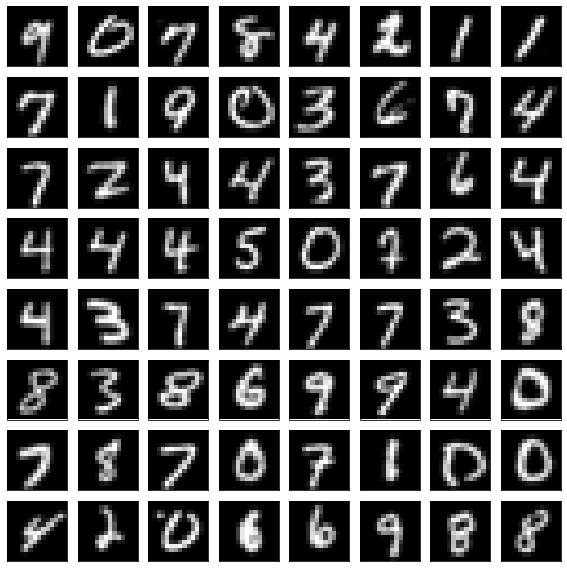

In [4]:
indices = np.random.choice(len(train_data), size=64)
samples = torch.vstack([train_data[idx][0] for idx in indices])
fig = plot_grid_of_mnist_samples(samples, grid=(8,8))

Note that the data lie within the range $[0, 1]$.

Min value: 0.0
Max value: 1.0


(array([292086.,  15929.,  12016.,  11001.,  11707.,  10449.,  11556.,
         11076.,   9913.,   6267.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

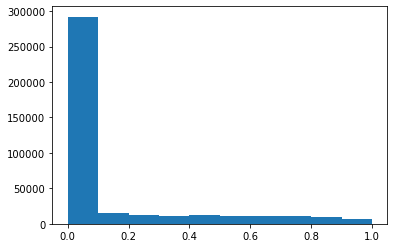

In [5]:
all_data = torch.vstack([x for x, _ in train_data])
print('Min value:', all_data.min().item())
print('Max value:', all_data.max().item())

# Plot histogram for a random subset
subsample_size = 2000
indices = np.random.choice(all_data.shape[0], size=subsample_size, replace=False)
plt.hist(all_data[indices].flatten().numpy(), bins=np.linspace(0, 1, num=10))

## VAE for MNIST

We saw that a large portion of values are either 0 or 1, however, the number of values between 0 and 1 is non-zero, hence the support of the generative model should be $[0, 1]$. It is a [common error](https://proceedings.neurips.cc/paper/2019/hash/f82798ec8909d23e55679ee26bb26437-Abstract.html) in the VAE literature to use the Bernoulli distribution, whose support is binary, for data with support $[0, 1]$.  
NB: Remember to always check that the domain of the statistical model includes the domain of the data.

We here parametrise the generator with a recently proposed [continuous Bernoulli distribution](https://en.wikipedia.org/wiki/Continuous_Bernoulli_distribution), whose support lies in $[0, 1]$.

$$
p_{\theta}(\mathbf{x} \mid \mathbf{z}) = \mathcal{CB}\left(\mathbf{x}; \eta \right) = \prod_{d=1}^D \mathcal{CB}\left(x_d; \eta_d \right), \text{ and } \eta_d = \text{sigmoid}(f_{\theta}(\mathbf{z})_d)
$$

where $\eta_d \in (0, 1)$ are the parameters of the continuous Bernoulli distribution, $\mathbf{f}_{\theta}(\mathbf{\cdot})$ is a neural network that takes $\mathbf{z}$ as input and outputs unconstrained parameters (we call them logits), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) transforms the logit parameters to the range $(0, 1)$. 

As is common in the VAE literature, we choose the prior distribution over the latents $p(\mathbf{z})$ as standard Gaussian

$$
p(\mathbf{z}) = \mathcal{N}\left(\mathbf{z}; \mathbf{0}, \mathbf{1}\right)
$$

and specify the variational distribution family as a diagonal Gaussian
$$
q_{\phi}(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}\left(\mathbf{z}; \mu, \text{diag}(\sigma) \right) = \prod_{k=1}^H \mathcal{N}\left(z_k; \mu_k, \sigma_k\right), \text{ and } \sigma_k = \exp(0.5 \gamma_{\phi}(\mathbf{x})_k), \quad \mu_k = \mu_{\phi}(\mathbf{x})_k
$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the independent Gaussians (note that different to the lecture slides we denote the Gaussian distribution in terms of the standard deviation, not variance, since the implementation in PyTorch takes mean and standard deviation as arguments), $\mu_{\phi}(\mathbf{\cdot})$ and $\gamma_{\phi}(\mathbf{\cdot})$ are neural networks that take $\mathbf{x}$ as input and output the parameters---mean and log-variance---of the variational distribution, and $\mu_k$ and $\sigma_k$ (and $\gamma_{\phi}(\mathbf{x})_k$) are the corresponding $k$-th constrained (and unconstrained) parameters.

In this setting where the prior and the variational distributions are both Gaussians the per-data-point variational ELBO is better rewritten as

$$
\mathcal{L}_i(\theta, \phi) = \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log \frac{p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) p(\mathbf{z})}{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\right] = \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \middle|\middle| p(\mathbf{z})\right)
$$

The KL divergence between two Gaussians can be computed analytically and in the current setting becomes

$$
\text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \middle|\middle| p(\mathbf{z})\right) = -\frac{1}{2} \sum_{k=1}^K(1 + \log ((\sigma_k)^2) - (\mu_k)^2 - (\sigma_k)^2), \text{ where } \sigma_k = \exp(0.5 \gamma_{\phi}(\mathbf{x}^i)_k), \quad \mu_k = \mu_{\phi}(\mathbf{x}^i)_k.
$$

Below we provide the code for evaluating the log probabilities of the generator $p_{\theta}(\mathbf{x}\mid \mathbf{z})$ and the variational distribution $q_{\phi}(\mathbf{z}\mid \mathbf{x})$.

In [6]:
def evaluate_logprob_continuous_bernoulli(X, *, logits):
    """
    Evaluates log-probability of the continuous Bernoulli distribution

    Args:
        X (Tensor):      data, a batch of shape (B, D)
        logits (Tensor): parameters of the continuous Bernoulli,
                         a batch of shape (B, D) 

    Returns:
        logpx (Tensor): log-probabilities of the inputs X, a batch of shape (B,)
    """
    cb = torch.distributions.ContinuousBernoulli(logits=logits)
    return cb.log_prob(X).sum(dim=-1)

def evaluate_logprob_diagonal_gaussian(Z, *, mean, logvar):
    """
    Evaluates log-probability of the diagonal Gaussian distribution

    Args:
        Z (Tensor):      latent vectors, a batch of shape (*, B, H)
        mean (Tensor):   mean of diagonal Gaussian, a batch of shape (*, B, H)
        logvar (Tensor): log-variance of diagonal Gaussian, a batch of shape (*, B, H)

    Returns:
        logqz (Tensor): log-probabilities of the inputs Z, a batch of shape (*, B)
                        where `*` corresponds to any additional dimensions of the input arguments,
                        for example a dimension representing the samples used to approximate 
                        the expectation in the ELBO
    """
    gauss = torch.distributions.Normal(loc=mean, scale=torch.exp(0.5*logvar))
    return gauss.log_prob(Z).sum(dim=-1)


#### Exercise 1

Using the formula above of the $\text{KL}(q_{\phi}(\mathbf{z}\mid \mathbf{x}^i)||p(\mathbf{z}))$ for diagonal Gaussian $q$ and standard Gaussian $p$ implement the following code for computing the KL divergence for a (mini-)batch of variational distributions $q(\mathbf{z} \mid \mathbf{x}^1) \ldots q(\mathbf{z} \mid \mathbf{x}^B)$.

</br>
<details><summary><a>Solution</a></summary>

The code solution is provided below, if you're struggling with the task you can simply copy the solution below into the provided location below. If you use the provided solution, make sure you understand what the code does.
    
```python
q_var = q_logvar.exp()
    
kld = -0.5 * (1 + q_logvar - q_mean**2 - q_var).sum(dim=-1)
```

</details>

In [7]:
def compute_kld_with_standard_gaussian(q_mean, q_logvar):
    """
    Computes KL(q(z|x)||p(z)) between the variational diagonal 
    Gaussian distribution q and standard Gaussian prior p
    
    Args:
        q_mean (Tensor):   mean of diagonal Gaussian q, a batch of shape (B, H)
        q_logvar (Tensor): log-variance of diagonal Gaussian q, a batch of shape (B, H)
        
    Returns:
        kld (Tensor): KL divergences between q and p, a batch of shape (B,)
    """
    ### IMPLEMENT YOUR CODE HERE
    
    # q_var = ...
    
    # kld = ...
    
    q_var = q_logvar.exp()
    
    kld = -0.5 * (1 + q_logvar - q_mean**2 - q_var).sum(dim=-1)
    
    ###
    return kld


## Gradients of the variational ELBO

To optimise the model we will iteratively maximise the averaged variational lower-bound $\sum_i \mathcal{L}_i(\theta, \phi)$ with stochastic gradient ascent. This requires us to obtain gradients of $\mathcal{L}_i(\theta, \phi)$ with respect to both $\theta$ and $\phi$. 

$$
\begin{align}
\nabla_{\theta, \phi} \mathcal{L}_i &= \nabla_{\theta, \phi} \left\{ \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right) \right\}\\
&= \nabla_{\theta, \phi} \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)
\end{align}
$$

Since the KL divergence term can be computed analytically, we can obtain their gradients by using off-the-shelf autograd tools available in PyTorch.


However, the first expectation $\mathbb{E}_{q_{\phi}}[\cdot]$ depends on the parameters $\phi$, which complicates the computation of its gradients. Below we discuss two of the most common ways for obtaining gradients of the variational model: the pathwise gradient estimator and the score function gradient estimator.


### Pathwise gradient estimator (reparametrisation trick)

The pathwise gradient estimator, also commonly known as the [reparametrisation trick](https://arxiv.org/abs/1312.6114), relies on the sampling path of the variational samples. In general, the estimator requires that sampling of the variational distribution must be decomposable into a parametric, deterministic, and differentiable transformation $\mathbf{t}(\cdot; \phi)$ of samples $\epsilon$ from an auxilliary noise distribution $n(\epsilon)$ without learnable parameters

$$
\mathbf{z} \sim q_{\phi}(\mathbf{z}) \Leftrightarrow \mathbf{z} = \mathbf{t}(\epsilon; \phi) \text{ with }  \epsilon \sim n(\epsilon).
$$

The gradients obtained using the pathwise gradient estimator are often low-variance, and hence are often preferred over the other approaches if available.


#### Exercise 2

Show that the gradients of the per data-point lower-bound $\mathcal{L}_i(\theta, \phi)$ are

$$
\nabla_{\theta, \phi} \mathcal{L}_i(\theta, \phi) = \mathbb{E}_{n(\epsilon)}\left[ \nabla_{\theta, \mathbf{z}} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})^\top \nabla_{\theta, \phi} \mathbf{t}(\epsilon; \phi)\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)
$$

using the reparametrisation $\mathbf{z} = \mathbf{t}(\epsilon; \phi)$. Since the gradients of the analytically computable KL term can be obtained via off-the-shelf autograd tools you can just denote them $\nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)$.

<details><summary><a>Answer (click)<a></summary>The pathwise gradients of the lower-bound can be derived as follows

$$
\begin{align}
\nabla_{\theta, \phi} \mathcal{L}(\theta, \phi) &= \nabla_{\theta, \phi} \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\log p_{\theta}(\mathbf{x} \mid \mathbf{z})\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)\\
&= \nabla_{\theta, \phi} \mathbb{E}_{n(\epsilon)}\left[\log p_{\theta}(\mathbf{x} \mid \mathbf{t}(\epsilon; \phi))\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)\\
&= \mathbb{E}_{n(\epsilon)}\left[ \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x} \mid \mathbf{t}(\epsilon; \phi))\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right)\\
&= \mathbb{E}_{n(\epsilon)}\left[ \nabla_{\theta, \mathbf{z}} \log p_{\theta}(\mathbf{x} \mid \mathbf{z})^\top \nabla_{\theta, \phi} \mathbf{t}(\epsilon; \phi)\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \mid\mid p(\mathbf{z})\right), \text{ with } \mathbf{z} = \mathbf{t}(\epsilon; \phi).
\end{align}
$$

Thus, the gradients of $\phi$ can be obtained as long as the variational distribution can be reparametrised via a differentiable transformation $\mathbf{t}(\cdot; \phi)$.
In practice the expectation is approximated by Monte Carlo averaging and the gradients are computed as an average over samples $\epsilon_1, \ldots, \epsilon_M$  from the noise distribution $n(\epsilon)$. 

It is important to note that the derivatives in the final line can then be obtained by off-the-shelf autograd tools available in most ML frameworks.
</details> 



#### Exercise 3

Implement a function $\mathbf{t}(\epsilon; \mu, \sigma)$ that samples from a Gaussian distribution $\mathcal{N}(z; \mu, \sigma)$ without using the default PyTorch implementation.

</br>
<details><summary><a>Hint 1 (click)<a></summary>Use the standard Gaussian distribution for the "noise".</details> 
<details><summary><a>Hint 2 (click)<a></summary>A univariate Gaussian $\mathcal{N}(z; \mu, \sigma)$ can be reparametrised as $z = \mu + \sigma\epsilon$ with $\epsilon \sim \mathcal{N}(0, 1)$.</details> 
<details><summary><a>Solution</a></summary>

The code solution is provided below, if you're struggling with the task you can simply copy the solution below into the provided location below. If you use the provided solution, make sure you understand what the code does.
    
```python
std = torch.exp(0.5*logvar)
eps = torch.randn(torch.Size([num_samples]) + std.shape, dtype=std.dtype, device=std.device)

Z = mean + eps*std
```

</details>

In [8]:
def sample_gaussian_with_reparametrisation(mean, logvar, *, num_samples=1):
    """
    Samples the Gaussian distribution using the reparametrisation trick
    
    Args:
        mean (Tensor):     mean of diagonal Gaussian q, a batch of shape (B, K)
        logvar (Tensor):   log-variance of diagonal Gaussian q, a batch of shape (B, K)
        num_samples (int): The number of samples (M) to approximate the expectation in the ELBO
    
    Returns:
        Z (Tensor):        Samples Z from the diagonal Gaussian q, a batch of shape (num_samples, B, K)
    """
    ### IMPLEMENT YOUR CODE HERE
    
    # std = ...
    # eps = ...
    
    # Z = ...
    
    std = torch.exp(0.5*logvar)
    eps = torch.randn(torch.Size([num_samples]) + std.shape,
                      dtype=std.dtype, device=std.device)
    
    Z = mean + eps*std
    ###
    
    # Making sure that the variational samples are on the same device as the input argument (i.e. CPU or GPU)
    return Z.to(device=std.device)

#### Exercise 4

Now that we can obtain samples $z$ via the reparametrised sampling, implement the variational ELBO using the reparametrised samples

$$
\mathcal{L}_i(\theta, \phi) = \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \middle|\middle| p(\mathbf{z})\right)
$$

</br>
<details><summary><a>Hint (click)<a></summary>Use the code implemented earlier.</details> 
<details><summary><a>Solution</a></summary>

The code solution is provided below, if you're struggling with the task you can simply copy the solution below into the provided location below. If you use the provided solution, make sure you understand what the code does.
    
```python
# KLD( q(z|x) || p(z) )
kld = compute_kld_with_standard_gaussian(mean, logvar)  # (B,)

# ~E_{q(z|x)}[ p(x | z) ]
neg_cross_entropy = evaluate_logprob_continuous_bernoulli(X, logits=logits).mean(dim=0)  # (B,)

# ELBO for each data-point
elbos = neg_cross_entropy - kld  # (B,)
```

</details>

In [9]:
def elbo_with_pathwise_gradients(X, *, encoder, decoder, num_samples):
    """
    Evaluate the ELBO for each data-point in X
    
    Args:
        X (Tensor):                 data, a batch of shape (B, D)
        decoder (torch.nn.Module):  is a neural network that provides the parameters
                                    of the generative model p(x|z; θ)
        encoder (torch.nn.Module):  is a neural network that provides the parameters 
                                    of the variational distribution q(z|x; φ).
        num_samples (int):          the number of samples used in the Monte Carlo averaging

    Returns:
        elbos (Tensor):             the ELBOs for each input X, a tensor of shape (B,)
    """
    # Evaluate the encoder network to obtain the parameters of the 
    # variational distribution
    mean, logvar = encoder(X)  # (B, H), (B, H)
    
    # Sample the latents using the reparametrisation trick
    Z = sample_gaussian_with_reparametrisation(
            mean, logvar, num_samples=num_samples)  # (M, B, H)

    # Evaluate the decoder network to obtain the parameters of the 
    # generative model p(x|z)
    logits = decoder(Z)  # (M, B, D)
    
    ### IMPLEMENT YOUR CODE BELOW
    
    # KLD( q(z|x) || p(z) )
    # kld = ...  # (B,)

    # ~E_{q(z|x)}[ p(x | z) ]
    # neg_cross_entropy = ...  # (B,)

    # ELBO for each data-point
    # elbos = ...  # (B,)

    # KLD( q(z|x) || p(z) )
    kld = compute_kld_with_standard_gaussian(mean, logvar)  # (B,)

    # ~E_{q(z|x)}[ p(x | z) ]
    neg_cross_entropy = evaluate_logprob_continuous_bernoulli(X, logits=logits).mean(dim=0)  # (B,)
    
    # ELBO for each data-point
    elbos = neg_cross_entropy - kld  # (B,)
    ###
    
    return elbos

### Score function gradient estimator (optional, not examinable)

While the pathwise gradient, where available, is often preferred in practice due to its simplicity and low variance, many variational distributions cannot be reparametrised, such as discrete distributions. 
We can then use the [score function gradient estimator](https://arxiv.org/abs/1401.0118), also often known as the REINFORCE gradients in reinforcement learning literature.

$$
\begin{align}
\nabla_{\theta, \phi} \mathcal{L}_i(\theta, \phi) &= \nabla_{\theta, \phi} \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)}\left[\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \nabla_{\theta, \phi} \int q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) \text{d}{\mathbf{z}} - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \int \nabla_{\theta, \phi} \left( q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) \right) \text{d}{\mathbf{z}} - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \int \left(\nabla_{\theta, \phi} \left\{ q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)\right\} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right) \text{d}{\mathbf{z}} - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \int \left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \nabla_{\theta, \phi} \left\{ \log q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)\right\} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right) \text{d}{\mathbf{z}} - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \int q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \left( \nabla_{\theta, \phi} \left\{\log q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)\right\} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right) \text{d}{\mathbf{z}} - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x}^i)} \left[ \nabla_{\theta, \phi} \left\{\log q_{\phi}(\mathbf{z} \mid \mathbf{x})\right\} \log p_{\theta}(\mathbf{x} \mid \mathbf{z}) + \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right),
\end{align}
$$

where in the third equation we used the [dominated convergence theorem](https://en.wikipedia.org/wiki/Leibniz_integral_rule#Measure_theory_statement) to swap the integral and the gradient, and in the fifth equation we used the log-derivative trick $\nabla f(x) = f(x) \nabla \log f(x)$. 
The gradients can be obtained as long as $\log q_{\phi}(\mathbf{z} \mid \mathbf{x})$ is differentiable with respect to the parameters $\phi$.
In practice the expectation in the last line is approximated by Monte Carlo averaging and the gradients are then the average gradients over samples $\mathbf{z}_1, \ldots, \mathbf{z}_M \sim q_{\phi}(\mathbf{z} \mid \mathbf{x})$.

Importantly, as with the pathwise gradients, we can use off-the-shelf autograd tools, available in most ML frameworks to obtain the necessary gradients.

In this tutorial we will compare VAE fitting when using the pathwise and score function gradient estimators. 
We will therefore use a variational distribution for which the reparametrisation is available (i.e. Gaussian) but to evaluate the method with score function gradient estimator we will simulate a non-reparametrisable distribution by [detaching](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) the computation graph to stop the _pathwise_ gradients. The below code implements the non-reparametrised Gaussian sampling. We will then ask you to implement a surrogate ELBO, which enables model estimation using the score function gradient estimator.

In [10]:
def sample_gaussian_without_reparametrisation(mean, logvar, *, num_samples=1):
    """
    Samples the Gaussian distribution without attaching then to the computation graph
    
    Args:
        mean (Tensor):   mean of diagonal Gaussian q, a batch of shape (B, K)
        logvar (Tensor): log-variance of diagonal Gaussian q, a batch of shape (B, K)
        num_samples (int): The number of samples (M) to approximate the expectation in the ELBO
    
    Returns:
        Z (Tensor):      Samples Z from the diagonal Gaussian q, a batch of shape (num_samples, B, K)
    """
    return sample_gaussian_with_reparametrisation(mean, logvar, num_samples=num_samples).detach()

#### Exercise 5 (optional, not examinable)

Implement a surrogate variational ELBO $\mathcal{\tilde L}_i(\theta,\phi)$, which enables the optimisation of a VAE and uses the score function gradient estimator.

</br>
<details><summary><a>Hint 1 (click)<a></summary>Use the code implemented earlier.</details> 
<details><summary><a>Hint 2 (click)<a></summary>

You might want to use the [`Tensor.detach()`](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) function to create the surrogate ELBO with score function gradients. When a detached term appears in the loss, it will be treated as constant with respect to the variables of differentiation (i.e. the parameters).
</details>  
<details><summary><a>Hint 3 (click)<a></summary>
    
For an example of score fuction gradient estimator implementation in PyTorch read [here](https://pytorch.org/docs/stable/distributions.html#score-function).
</details>
<details><summary><a>Spoiler 1! Click this to see the surrogate ELBO.<a></summary>

We can write down the surrogate ELBO as follows

$$
\mathcal{\tilde L}_i(\theta, \phi) = \mathbb{E}_{\text{sg}\{q_{\phi}(\mathbf{z}\mid \mathbf{x}^i)\}} \left[ \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + \log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \text{sg}\{\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\} - \text{sg}\{\log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\} \right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right),
$$

where we use a stop-gradient operator $\text{sg}(\cdot)$ to stop gradient flow, equivalent to the `Tensor.detach()`.

Taking the gradient of the above, treating the $\text{sg}(\cdot)$ as constants, yields the same score function gradients we have derived above

$$
\begin{align}
\nabla_{\theta, \phi} \mathcal{\tilde L}_i(\theta, \phi) &= \nabla_{\theta, \phi} \mathbb{E}_{\text{sg}\{q_{\phi}(\mathbf{z}\mid \mathbf{x}^i)\}} \left[ \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + \log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \text{sg}\{\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\} - \text{sg}\{\log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\} \right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \mid\mid p(\mathbf{z})\right)\\
&= \mathbb{E}_{q_{\phi}(\mathbf{z}\mid \mathbf{x}^i)} \left[ \nabla_{\theta, \phi} \left\{ \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\right\} + \nabla_{\theta, \phi} \left\{\log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \text{sg}\{\log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\}\right\} - \nabla_{\theta, \phi}\left\{\text{sg}\{\log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z})\}\right\} \right] \\&\phantom{====}- \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \middle|\middle| p(\mathbf{z})\right)\\
&= \mathbb{E}_{q_{\phi}(\mathbf{z}\mid \mathbf{x}^i)} \left[ \nabla_{\theta, \phi} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) + \nabla_{\theta, \phi} \left\{\log q_{\phi}(\mathbf{z}\mid \mathbf{x}^i) \right\} \log p_{\theta}(\mathbf{x}^i \mid \mathbf{z}) \right] - \nabla_{\theta, \phi} \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}^i) \middle|\middle| p(\mathbf{z})\right)\\
&= \nabla_{\theta, \phi} \mathcal{L}_i(\theta, \phi)
\end{align}
$$
</details>
<details><summary><a>Solution</a></summary>

For this optional task we provide you with the solution below, simply copy it to the appropriate location in the code cell below.
    
```python
# KLD( q(z|x) || p(z) )
kld = compute_kld_with_standard_gaussian(mean, logvar)

# log p(x | z)
log_px_given_z = evaluate_logprob_continuous_bernoulli(X, logits=logits)

# ~E_{q(z|x)}[ p(x | z) ]
neg_cross_entropy = log_px_given_z.mean(dim=0)

# Per data-point ELBO, note that this ELBO will not estimate the gradients of the expectation parameters!
elbos = neg_cross_entropy - kld

# log q(z | x)
log_qz_given_x = evaluate_logprob_diagonal_gaussian(Z, mean=mean, logvar=logvar)

# Surrogate loss for score function gradient estimator
surrogate_loss = (log_qz_given_x*log_px_given_z.detach()).mean(dim=0)

# ELBO with score function gradients
surrogate_elbos = elbos + surrogate_loss - surrogate_loss.detach()
```

</details>

In [11]:
def elbo_with_score_function_gradients(X, *, encoder, decoder, num_samples):
    """
    Evaluate the surrogate ELBO for each data-point in X. The surrogate
    elbo uses score function gradient estimator to estimate the gradients
    of the variational distribution.
    
    Args:
        X (Tensor):                 data, a batch of shape (B, D)
        decoder (torch.nn.Module):  is a neural network that provides the parameters
                                    of the generative model p(x|z; θ)
        encoder (torch.nn.Module):  is a neural network that provides the parameters 
                                    of the variational distribution q(z|x; φ).
        num_samples (int):          the number of samples used in the Monte Carlo averaging
    
    Returns:
        elbos (Tensor):             the ELBOs for each input X, a tensor of shape (B,)
    """
    # Evaluate the encoder network to obtain the parameters of the 
    # variational distribution
    mean, logvar = encoder(X)  # (B, H), (B, H)
    
    # Sample the latents _without_ the reparametrisation trick
    Z = sample_gaussian_without_reparametrisation(
            mean, logvar, num_samples=num_samples)  # (M, B, H)

    # Evaluate the decoder network to obtain the parameters of the 
    # generative model p(x|z)
    logits = decoder(Z)  # (M, B, D)
    
    ### IMPLEMENT YOUR CODE BELOW
    
    #
    # ELBO
    #
    
    # KLD( q(z|x) || p(z) )
    # kld = ...

    # log p(x | z)
    # log_px_given_z = ...
    
    # ~E_{q(z|x)}[ p(x | z) ]
    # neg_cross_entropy = ...
    
    # Per-data-point ELBO that does not estimate the gradients of the expectation parameters
    # elbos = ...
    
    #
    # Score function surrogate
    #

    # log q(z | x)
    # log_qz_given_x = ...

    # Surrogate loss for score function gradient estimator of the expectation parameters
    # surrogate_loss = ...

    # ELBO with score function gradients
    # surrogate_elbos = ...
    
    #
    # ELBO
    #

    # KLD( q(z|x) || p(z) )
    kld = compute_kld_with_standard_gaussian(mean, logvar)

    # log p(x | z)
    log_px_given_z = evaluate_logprob_continuous_bernoulli(X, logits=logits)
    
    # ~E_{q(z|x)}[ p(x | z) ]
    neg_cross_entropy = log_px_given_z.mean(dim=0)
    
    # Per data-point ELBO, note that this ELBO will not estimate the gradients of the expectation parameters!
    elbos = neg_cross_entropy - kld
    
    #
    # Score function surrogate
    #

    # log q(z | x)
    log_qz_given_x = evaluate_logprob_diagonal_gaussian(Z, mean=mean, logvar=logvar)

    # Surrogate loss for score function gradient estimator
    surrogate_loss = (log_qz_given_x*log_px_given_z.detach()).mean(dim=0)

    # ELBO with score function gradients
    surrogate_elbos = elbos + surrogate_loss - surrogate_loss.detach()
    
    ###
    return surrogate_elbos

## VAE implementation

Below we implement the PyTorch models for the encoder and decoder networks as well as a wrapper model to represent the VAE using the functions you have implemented above. You should read the code and understand it.

We will use simple fully-connected neural networks but feel free to experiment with other neural network architectures, such as residual networks or convolutional layers, which can often improve the performance of the method for specific tasks.

In [12]:
class Encoder(nn.Module):
    """
    Encoder or inference network that predicts the parameters of the variational distribution q(z|x).
    """
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        enc_layer_dims = self.hparams.enc_layer_dims

        # Create all layers except last
        layers = []
        for i in range(len(enc_layer_dims)-2):
            layers.append(nn.Linear(enc_layer_dims[i],
                                    enc_layer_dims[i+1]))
            # Use a non-linearity
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

        # Create separate final layers for each parameter (mean and log-variance)
        # We use log-variance to unconstrain the optimisation of the positive-only variance parameters
        self.mean = nn.Linear(enc_layer_dims[-2],
                              enc_layer_dims[-1])
        self.logvar = nn.Linear(enc_layer_dims[-2],
                                enc_layer_dims[-1])

    @staticmethod
    def add_model_args(parser):
        """Here we define the arguments for our encoder model."""
        parser.add_argument('--enc_layer_dims', type=int, nargs='+',
                            help='Encoder layer dimensions.')
        return parser
    
    def forward(self, X):
        """
        Predicts the parameters of the variational distribution
        
        Args:
            X (Tensor):      data, a batch of shape (B, D)
            
        Returns:
            mean (Tensor):   means of the variational distributions, shape (B, K)
            logvar (Tensor): log-variances of the diagonal Gaussian variational distribution, shape (B, K)
        """
        features = self.model(X)
        mean = self.mean(features)
        logvar = self.logvar(features)
        
        return mean, logvar

    def sample_with_reparametrisation(self, mean, logvar, *, num_samples=1):
        # Reuse the implemented code
        return sample_gaussian_with_reparametrisation(mean, logvar, num_samples=num_samples)

    def sample_without_reparametrisation(self, mean, logvar, *, num_samples=1):
        # Reuse the implemented code
        return sample_gaussian_without_reparametrisation(mean, logvar, num_samples=num_samples)
    
    def log_prob(self, mean, logvar, Z):
        """
        Evaluates the log_probability of Z given the parameters of the diagonal Gaussian
        
        Args:
            mean (Tensor):   means of the variational distributions, shape (*, B, K)
            logvar (Tensor): log-variances of the diagonal Gaussian variational distribution, shape (*, B, K)
            Z (Tensor):      latent vectors, shape (*, B, K)
        
        Returns:
            logqz (Tensor):  log-probability of Z, a batch of shape (*, B)
        """
        # Reuse the implemented code
        return evaluate_logprob_diagonal_gaussian(Z, mean=mean, logvar=logvar)

In [13]:
class Decoder(nn.Module):
    """
    Decoder or generative network that computes the parameters of the likelihood.
    """
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        dec_layer_dims = self.hparams.dec_layer_dims
        
        # Create all layers except last
        layers = []
        for i in range(len(dec_layer_dims)-2):
            layers.append(nn.Linear(dec_layer_dims[i],
                                    dec_layer_dims[i+1]))
            # Add non-linearity
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)
        # Create final layers that predicts the parameters of the continuous Bernoulli
        self.logits = nn.Linear(dec_layer_dims[-2],
                                dec_layer_dims[-1])
        
    @staticmethod
    def add_model_args(parser):
        """Here we define the arguments for our decoder model."""
        parser.add_argument('--dec_layer_dims', type=int, nargs='+',
                            help='Decoder layer dimensions.')
        return parser

    def forward(self, Z):
        """
        Computes the parameters of the generative distribution p(x | z)
        
        Args:
            Z (Tensor):  latent vectors, a batch of shape (M, B, K)
            
        Returns:
            logits (Tensor):   parameters of the continuous Bernoulli, shape (M, B, D)
        """
        features = self.model(Z)
        logits = self.logits(features)

        return logits

    def log_prob(self, logits, X):
        """
        Evaluates the log_probability of X given the parameters of the continuous Bernoulli
        
        Args:
            logits (Tensor): parameters of the continuous Bernoulli, shape (*, B, D)
            X (Tensor):      data, shape (*, B, D)
        
        Returns:
            logpx (Tensor):  log-probability of X, a batch of shape (*, B)
        """
        # Reuse the implemented code
        return evaluate_logprob_continuous_bernoulli(X, logits=logits)
    
    # Some extra methods for analysis
    
    def sample(self, logits, *, num_samples=1):
        """
        Samples the continuous Bernoulli
        
        Args:
            logits (Tensor):   parameters of the continuous Bernoulli, shape (*, B, D)
            num_samples (int): number of samples
        
        Returns:
            X (Tensor):  samples from the distribution, shape (num_samples, *, B, D)
        """
        cb = torch.distributions.ContinuousBernoulli(logits=logits)
        return cb.sample((num_samples,))

    def mean(self, logits):
        """
        Returns the mean of the continuous Bernoulli
        
        Args:
            logits (Tensor):   parameters of the continuous Bernoulli, shape (*, B, D)
        
        Returns:
            mean (Tensor):  means of the continuous Bernoulli, shape (*, B, D)
        """
        cb = torch.distributions.ContinuousBernoulli(logits=logits)
        return cb.mean
    
    def param_p(self, logits):
        """
        Returns the success probability p of the continuous Bernoulli
        
        Args:
            logits (Tensor):   parameters of the continuous Bernoulli, shape (*, B, D)
        
        Returns:
            p (Tensor):  success probability p of the continuous Bernoulli, shape (*, B, D)
        """
        cb = torch.distributions.ContinuousBernoulli(logits=logits)
        return cb.probs


In [14]:
class VAE(nn.Module):
    """
    A wrapper for the VAE model
    """
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        
        # Use the encoder and decoder implemented above
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        
    @staticmethod
    def add_model_args(parser):
        """Here we define the arguments for our decoder model."""
        parser = Encoder.add_model_args(parser)
        parser = Decoder.add_model_args(parser)
        
        parser.add_argument('--gradient_type', type=str,
                            choices=['pathwise', 'score'],
                            help='Variational model gradient estimation method.')
        parser.add_argument('--num_variational_samples', 
                            type=int, default=1,
                            help=('The number of samples from the variational '
                                  'distribution to approximate the expectation.'))
        
        return parser

    def forward(self, X):
        """
        Computes the variational ELBO
        
        Args:
            X (Tensor):  data, a batch of shape (B, K)
            
        Returns:
            elbos (Tensor): per data-point elbos, shape (B, D)
        """
        if self.hparams.gradient_type == 'pathwise':
            return self.elbo_with_pathwise_gradients(X)
        elif self.hparams.gradient_type == 'score':
            return self.elbo_with_score_function_gradients(X)
        else:
            raise ValueError(f'gradient_type={self.hparams.gradient_type} is invalid')
            
    def elbo_with_pathwise_gradients(self, X):
        # Reuse the implemented code
        return elbo_with_pathwise_gradients(X, encoder=self.encoder, decoder=self.decoder, 
                                            num_samples=self.hparams.num_variational_samples)
        
    def elbo_with_score_function_gradients(self, X):
        # Reuse the implemented code
        return elbo_with_score_function_gradients(X, encoder=self.encoder, decoder=self.decoder, 
                                                  num_samples=self.hparams.num_variational_samples)


#### Exercise 6

We want you to be able to read, understand, and reason about scientific code. The following questions are here to facilitate your thoughts.

1. What do the `Decoder.forward()` and `Encoder.forward()` methods do?
2. What would you have to change about the model and code if the data had a different domain, for example the whole real domain $\mathbb{R}^D$ instead of only $[0, 1]^D$?

<details><summary><a>Answer (click)<a></summary>
    
1. The `Decoder.forward()` predicts the parameters of the pdf (or pmf) of the conditional distribution $p_{\theta}(\mathbf{x}\mid\mathbf{z})$, and the `Encoder.forward()` predicts the parameters of the pdf (or pmf) of variational distribution $q_{\phi}(\mathbf{z}\mid \mathbf{x})$.

2. If the data had been distributed in the whole real domain we could specify a different generative distribution $p_{\theta}(\mathbf{x} \mid \mathbf{z})$, for example using a low-rank Gaussian or Student's-T distribution. You would then have to implement a decoder, which predicts the mean and covariance matrices of the Gaussian (or equivalently the parameters of the Student's-T), and use the corresponding probability density function when computing the ELBO, i.e. change the computations of the `neg_cross_entropy` variable in the provided solutions.

</details>



#### Exercise 7 (optional, not examinable)

1. If you wanted to use a different lower-bound, for example the [importance-weighted ELBO](https://arxiv.org/abs/1509.00519)
$$
\mathcal{L}^{IW}_i(\theta, \phi) = \mathbb{E}_{\mathbf{z}_1 \ldots \mathbf{z}_T \sim q_{\phi}(\mathbf{z}\mid\mathbf{x}^i)} \left[ \log \frac{1}{T} \sum_{t=1}^T \frac{p_{\theta}(\mathbf{x}^i, \mathbf{z}_t)}{q_{\phi}(\mathbf{z}_t \mid \mathbf{x}^i)}\right]
$$
which parts of the code would you change?
2. How would you compute the term inside the expectation $\log \frac{1}{T} \sum_{t=1}^T \frac{p_{\theta}(\mathbf{x}, \mathbf{z}_t)}{q_{\phi}(\mathbf{z}_t \mid \mathbf{x})}$?
<details><summary><a>Hint (click)<a></summary>Think about the numerical stability of the computation.</details>

<details><summary><a>Answer (click)<a></summary>
    
1. You could simply replace the code in the `VAE.forward()` method with the computation of the $\mathcal{L}^{IW}_i$ above. Note that you would not be able to compute the KL divergence analytically as before, instead the whole ELBO would have to be approximated using Monte Carlo averaging.
  
  The importance-weighted ELBO (IWELBO) has some nice properties, for example, the IWELBO becomes monotonically tighter as you increase the number of importance samples $T$, and with $T=1$ it equals the standard ELBO, whereas with $T\rightarrow \infty$ it approaches marginal log-likelihood $\log p_{\theta}(\mathbf{x}^i)$. The IWELBO has been used for training more [accurate VAE models](https://arxiv.org/abs/1509.00519), estimating $\log p_{\theta}(\mathbf{x}^i)$ (see [here](http://bayesiandeeplearning.org/2018/papers/101.pdf)), and fitting VAEs in the presence of [missing variables](https://arxiv.org/abs/1812.02633).

2. Computations in the probability domain, such as $\frac{p_{\theta}(\mathbf{x}, \mathbf{z}_t)}{q_{\phi}(\mathbf{z}_t \mid \mathbf{x})}$, are often numerically unstable, especially when the random variables are high-dimensional. Instead it is best to perform any computations in the log-probability domain. You should note that the $\log \frac{1}{T} \sum_{t=1}^T \frac{p_{\theta}(\mathbf{x}, \mathbf{z}_t)}{q_{\phi}(\mathbf{z}_t \mid \mathbf{x})}$ term is a composition of a _log_, a _summation_, as well as $p_{\theta}(\mathbf{x}, \mathbf{z}_t)$ and $q_{\phi}(\mathbf{z}_t \mid \mathbf{x})$ terms which we have previously computed in the log-domain. Hence, to preserve numerical stability you should use the [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp)
$$
\begin{align}
\log \frac{1}{T} \sum_{t=1}^T \frac{p_{\theta}(\mathbf{x}, \mathbf{z}_t)}{q_{\phi}(\mathbf{z}_t \mid \mathbf{x})}
&=
- \log T + \log \sum_{t=1}^T \exp\left(\log p_{\theta}(\mathbf{x}, \mathbf{z}_t) - \log q_{\phi}(\mathbf{z}_t \mid \mathbf{x})\right) \\
&=
-\log T + r_{\text{amax}} - \log \sum_{t=1 }^T \mathbb{1}(t \not = \text{amax}) \exp\left(r_{t} - r_{\text{amax}}\right),
\end{align}
$$
where $r_t = \log p_{\theta}(\mathbf{x}, \mathbf{z}_t) - \log q_{\phi}(\mathbf{z}_t \mid \mathbf{x})$ and $\text{amax} = \mathrm{argmax}_t (\{r_1, \ldots, r_T\})$. This handy function is readily implemented in PyTorch as [`torch.logsumexp()`](https://pytorch.org/docs/stable/generated/torch.logsumexp.html).
</details>




### Training code

Below we provide an implementation of the training loop code that we will use to fit the VAE models.

First we define all hyperparameters used in the below code. You will be able to override the default values later.

In [15]:
def create_base_argparser():
    parser = argparse.ArgumentParser(description='VAE MNIST Example')
    parser.add_argument('--seed', type=int, default=20211201,
                        help='Random seed for reproducible runs.')
    parser.add_argument('--cuda', action='store_true', default=False,
                        help='Uses CUDA training if available (default: False)')
    parser.add_argument('--batch_size', type=int, default=50,
                        help='Batch size for training (default: 50)')
    parser.add_argument('--epochs', type=int, default=3000,
                        help='Number of epochs to train (default: 3000)')
    parser.add_argument('--learning_rate', type=float, default=1e-4,
                        help='Learning rate for the Adam optimiser (default: 0.0001)')
    return parser

parser = create_base_argparser()
parser = VAE.add_model_args(parser)
parser.print_help()

usage: ipykernel_launcher.py [-h] [--seed SEED] [--cuda]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS]
                             [--learning_rate LEARNING_RATE]
                             [--enc_layer_dims ENC_LAYER_DIMS [ENC_LAYER_DIMS ...]]
                             [--dec_layer_dims DEC_LAYER_DIMS [DEC_LAYER_DIMS ...]]
                             [--gradient_type {pathwise,score}]
                             [--num_variational_samples NUM_VARIATIONAL_SAMPLES]

VAE MNIST Example

optional arguments:
  -h, --help            show this help message and exit
  --seed SEED           Random seed for reproducible runs.
  --cuda                Uses CUDA training if available (default: False)
  --batch_size BATCH_SIZE
                        Batch size for training (default: 50)
  --epochs EPOCHS       Number of epochs to train (default: 3000)
  --learning_rate LEARNING_RATE
                        Learning rate for the Adam optimiser (default: 0.0001)
  -

We now implement the training loop that iterates over mini-batches of data and fits the model using stochastic gradient ascent. The below code monitors the ELBO on a held out test set and at the end of the training loads the model checkpoint corresponding to the best test ELBO.

In [16]:
def per_datapoint_elbo_to_avgelbo_and_loss(elbos):
    # Compute the average ELBO over the mini-batch
    elbo = elbos.mean(0)
    # We want to _maximise_ the ELBO, but the SGD implementations 
    # do minimisation by default, hence we multiply the ELBO by -1.
    loss = -elbo
    
    return elbo, loss

def create_dataloader(data, args):
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

    return torch.utils.data.DataLoader(
        data, batch_size=args.batch_size, shuffle=True, **kwargs)

def fit_model(model, optimizer, train_data, args, *, test_data=None):
    # We will plot the learning curves during training
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    # Create data loaders
    train_loader = create_dataloader(train_data, args)
    if test_data is not None:
        test_loader = create_dataloader(test_data, args)

    train_epochs = []
    train_elbos = []
    train_avg_epochs = []
    train_avg_elbos = []
    test_avg_epochs = []
    test_avg_elbos = []
    
    # We will use these to track the best performing model on test data
    best_avg_test_elbo = float('-inf')
    best_epoch = None
    best_model_state = None
    best_optim_state = None

    pbar = tqdm(range(1, args.epochs + 1))
    for epoch in pbar:
        # Train
        model.train()
        epoch_train_elbos = []
        # We don't use labels hence discard them with a _
        for batch_idx, (mbatch, _) in enumerate(train_loader):
            mbatch = mbatch.to(args.device)
            # Flatten the images
            mbatch = mbatch.view([-1] + [mbatch.shape[-2]*mbatch.shape[-1]])
            # Reset gradient computations in the computation graph
            optimizer.zero_grad()

            # Compute the loss for the mini-batch
            elbo, loss = per_datapoint_elbo_to_avgelbo_and_loss(model(mbatch))

            # Compute the gradients using backpropagation
            loss.backward()
            # Perform an SGD update
            optimizer.step()

            epoch_train_elbos += [elbo.detach().item()]
            pbar.set_description((f'Train Epoch: {epoch} [{batch_idx * len(mbatch)}/{len(train_loader.dataset)}'
                                  f'({100. * batch_idx / len(train_loader):.0f}%)] ELBO: {elbo:.6f}'))

        # Test
        if test_data is not None:
            with torch.inference_mode():
                model.eval()
                epoch_test_elbos = []
                for batch_idx, (mbatch, _) in enumerate(test_loader):
                    mbatch = mbatch.to(args.device)
                    # Flatten the images
                    mbatch = mbatch.view([-1] + [mbatch.shape[-2]*mbatch.shape[-1]])

                    # Compute the loss for the test mini-batch
                    elbo, loss = per_datapoint_elbo_to_avgelbo_and_loss(model(mbatch))

                    epoch_test_elbos += [elbo.detach().item()]
                    pbar.set_description((f'Test Epoch: {epoch} [{batch_idx * len(mbatch)}/{len(test_loader.dataset)} '
                                          f'({100. * batch_idx / len(test_loader):.0f}%)] ELBO: {elbo:.6f}'))

        # Store epoch summary in list
        train_avg_epochs += [epoch]
        train_avg_elbos += [np.mean(epoch_train_elbos)]
        train_epochs += np.linspace(epoch-1, epoch, len(epoch_train_elbos)).tolist()
        train_elbos += epoch_train_elbos
        if test_data is not None:
            test_avg_epochs += [epoch]
            epoch_avg_test_elbo = np.mean(epoch_test_elbos)
            test_avg_elbos += [epoch_avg_test_elbo]
            
            # Snapshot best model
            if epoch_avg_test_elbo > best_avg_test_elbo:
                best_avg_test_elbo = epoch_avg_test_elbo
                best_epoch = epoch
                
                best_model_state = deepcopy(model.state_dict())
                best_optim_state = deepcopy(optimizer.state_dict())

        # Update learning curve figure
        ax.clear()
        ax.plot(train_epochs, train_elbos, color='b', alpha=0.5, label='train')
        ax.plot(np.array(train_avg_epochs)-0.5, train_avg_elbos, color='b', label='train (avg)')
        if len(test_avg_elbos) > 0:
            ax.plot(np.array(test_avg_epochs)-0.5, test_avg_elbos, color='r', label='test (avg)')
        ax.grid(True)
        ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax.legend(loc='lower right')
        ax.set_ylabel('ELBO')
        ax.set_xlabel('Epoch')

        fig_title = f'Epoch: {epoch}, Avg. train ELBO: {np.mean(epoch_train_elbos):.2f}, Avg. test ELBO: {np.mean(epoch_test_elbos):.2f}'
        # If we are tracking best model, then also highlight it on the plot and figure title
        if best_avg_test_elbo != float('-inf'):
            fig_title += f', Best avg. test ELBO: {best_avg_test_elbo:.2f}'
            ax.scatter(best_epoch-0.5, best_avg_test_elbo, marker='*', color='r')
            

        fig.suptitle(fig_title, size=13)
        fig.tight_layout()
        display.clear_output(wait=True)
        if epoch != args.epochs:
            # Force display of the figure (except last epoch, where 
            # jupyter automatically shows the contained figure)
            display.display(fig)
        
    # Reset gradient computations in the computation graph
    optimizer.zero_grad()
    
    if best_model_state is not None and best_epoch != args.epochs:
        print(f'Loading best model state from epoch {best_epoch}.')
        model.load_state_dict(best_model_state)
    if best_optim_state is not None and best_epoch != args.epochs:
        print(f'Loading best optimizer state from epoch {best_epoch}.')
        optimizer.load_state_dict(best_optim_state)
        
    out = {
        'train_avg_epochs': train_avg_epochs,
        'train_avg_elbos': train_avg_elbos,
        'train_epochs': train_epochs,
        'train_elbos': train_elbos,
        'test_avg_epochs': test_avg_epochs,
        'test_avg_elbos': test_avg_elbos
    }
    return model, optimizer, out, fig

def save_state(model, optimizer, file):
    return torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, file)

def load_state(model, optimizer, file):
    checkpoint = torch.load(file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return

## Fit VAE with the pathwise gradient estimator

We now use the code we have implemented earlier to fit a VAE using the _pathwise gradient estimator_ for fitting the variational distribution.

We use simple one hidden layer neural network for the encoder and decoder, we approximate the expectation using one sample from the variational distribution, and use a learning rate of 0.001 with an Adam SGD optimiser. We train the model for 50 epochs over the training dataset.

In [17]:
# Specify the hyperpameter choices
data_dim = train_data[0][0].numel()
args_path = ['--dec_layer_dims', '2', '100', f'{data_dim}',
             '--enc_layer_dims', f'{data_dim}', '100', '2', 
             '--gradient_type', 'pathwise',
             '--num_variational_samples', '1',
             '--epochs', '50',
             '--learning_rate', '1e-3',
             '--cuda']

args_path = parser.parse_args(args_path)
args_path.cuda = args_path.cuda and torch.cuda.is_available()
args_path.device = torch.device("cuda" if args_path.cuda else "cpu")

# Seed all random number generators for reproducibility of the runs
seed_everything(args_path.seed)

# Initialise the model and the Adam (SGD) optimiser
model_path = VAE(args_path).to(args_path.device)
optimizer_path = optim.Adam(model_path.parameters(), lr=args_path.learning_rate)

The below experiment should not take longer than 20 minutes. If it takes too long, try to reduce the data dimensionality in the [MNIST section](#MNIST). After the first epoch is finished, the progress bar below will show the estimated time left.

If you do not wish to train the model yourself you can comment the following cell and uncomment the cell with `load_state(...)` code below.

Test Epoch: 50 [9950/10000 (100%)] ELBO: 367.921082: 100%|█| 50/50 [07:


Loading best model state from epoch 49.
Loading best optimizer state from epoch 49.


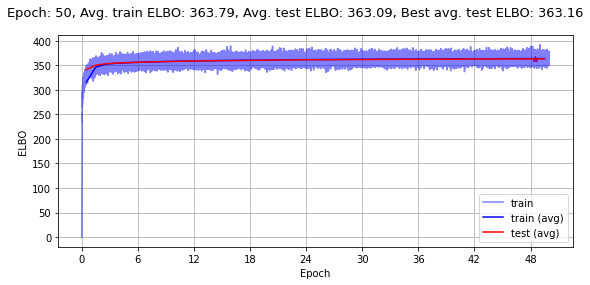

In [19]:
# Fit the VAE model
model_path, optimizer_path, out_path, fig = fit_model(model_path, optimizer_path, 
                                                      train_data, args_path,
                                                      test_data=test_data)

#### Snapshot

If you would like to save the trained model, uncomment the below. We have also provided code to load the saved model from a file (see the Jupyter cell before training).
See PyTorch documentation on [saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) models for more details.

In [20]:
# save_state(model_path, optimizer_path, 'VAE_path.pt')

You can load a pre-trained model by uncommenting the below line.

In [18]:
# Alternatively to training a model from scratch you can load a pre-trained model
# load_state(model_path, optimizer_path, 'VAE_path.pt')

## Fit VAE with score function gradient estimator (optional, not examinable)

We now use the code we have implemented earlier to fit a VAE using the _score function gradient estimator_ for fitting the variational distribution.

We use the same neural network architecture as before: a simple one hidden layer neural network for the encoder and decoder, and we approximate the expectation using one sample from the variational distribution.
Due to higher variance of the gradients we cannot use the same learning rate, hence we use a lower learning rate of 0.0001 with the Adam SGD optimiser. As before, we train the model for 50 epochs over the training dataset.

If you have not implemented the code in [Exercise 5](#Exercise-5-(optional%29), see the solution by clicking the highlighted text below the question and copy paste the solution into the code block below [Exercise 5](#Exercise-5-(optional%29), you can then proceed to run the following experiment.

In [21]:
# Specify the hyperpameter choices
data_dim = train_data[0][0].numel()
args_score = ['--dec_layer_dims', '2', '100', f'{data_dim}',
              '--enc_layer_dims', f'{data_dim}', '100', '2',
              '--gradient_type', 'score',
              '--num_variational_samples', '1',
              '--epochs', '50',
              '--learning_rate', '1e-4',
              '--cuda']

args_score = parser.parse_args(args_score)
args_score.cuda = args_score.cuda and torch.cuda.is_available()
args_score.device = torch.device("cuda" if args_score.cuda else "cpu")

# Seed all random number generators for reproducibility of the runs
seed_everything(args_score.seed)

# Initialise the model and the Adam (SGD) optimiser
model_score = VAE(args_score).to(args_score.device)
optimizer_score = optim.Adam(model_score.parameters(), lr=args_score.learning_rate)

The below experiment should not take longer than 20 minutes. If it takes too long, try to reduce the data dimensionality in the [MNIST section](#MNIST). After the first epoch is finished, the progress bar below will show the estimated time left.

If you do not wish to train the model yourself you can comment the following cell and uncomment the cell with `load_state(...)` code below.

Test Epoch: 50 [9950/10000 (100%)] ELBO: 350.910828: 100%|█| 50/50 [07:


Loading best model state from epoch 49.
Loading best optimizer state from epoch 49.


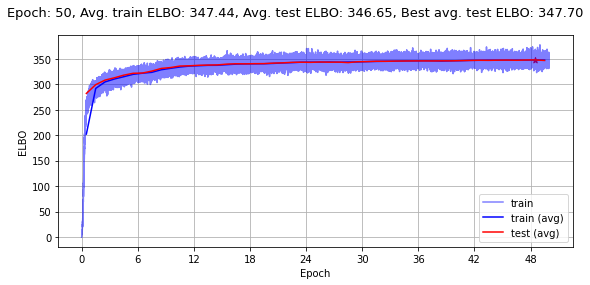

In [23]:
# Fit the VAE model
model_score, optimizer_score, out_score, fig = fit_model(model_score, optimizer_score,
                                                         train_data, args_score,
                                                         test_data=test_data)

#### Snapshot

If you would like to save the trained model, uncomment the below. We have also provided code to load the saved model from a file (see the Jupyter cell before training).
See PyTorch documentation on [saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) models for more details.

In [24]:
# save_state(model_score, optimizer_score, 'VAE_score.pt')

You can load a pre-trained model by uncommenting the below line.

In [22]:
# Alternatively to training a model from scratch you can load a pre-trained model
# load_state(model_score, optimizer_score, 'VAE_score.pt')

## Compare estimates using pathwise vs score function gradient estimators (optional, not examinable)

Below we plot the test ELBO curves against the training iterations for the VAEs fitted above with pathwise and score function gradient estimators. You should see the pathwise estimator method is performing significantly better than the score function estimator method. Since we kept most of the hyperparameters the same between the two methods, the performance gap can be attributed to the higher gradient variance of the score function estimator. 

In the following section we discuss one way to improve the performance of the score function estimator by reducing gradient variance.

Text(0.5, 0, 'Epoch')

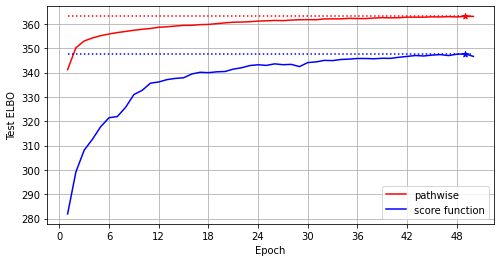

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(out_path['test_avg_epochs'], out_path['test_avg_elbos'], 
        color='r', label='pathwise')
amax = np.argmax(out_path['test_avg_elbos'])
ax.hlines(out_path['test_avg_elbos'][amax], 
          np.min(out_path['test_avg_epochs']), np.max(out_path['test_avg_epochs']),
         color='r', linestyles='dotted')
ax.scatter(out_path['test_avg_epochs'][amax], out_path['test_avg_elbos'][amax], color='r', marker='*')

ax.plot(out_score['test_avg_epochs'], out_score['test_avg_elbos'], 
        color='b', label='score function')
amax = np.argmax(out_score['test_avg_elbos'])
ax.hlines(out_score['test_avg_elbos'][amax], 
          np.min(out_score['test_avg_epochs']), np.max(out_score['test_avg_epochs']),
         color='b', linestyles='dotted')
ax.scatter(out_score['test_avg_epochs'][amax], out_score['test_avg_elbos'][amax], color='b', marker='*')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.grid(True)
ax.legend(loc='lower right')
ax.set_ylabel('Test ELBO')
ax.set_xlabel('Epoch')


## Variance reduction for score function estimator (optional, not examinable)

It is possible to reduce the gradient variance of the score function estimator by using [control variates](https://en.wikipedia.org/wiki/Control_variates). It works by replacing the function $f$ whose expectation is being approximated by Monte Carlo averaging with another function that has the same expectation but smaller variance.
In the case of the score function gradient estimation of the variational distribution parameters $\phi$, the function $f$ is

$$
f(\mathbf{z}; \mathbf{x}) = \nabla_{\phi} \left\{\log q_{\phi}(\mathbf{z} \mid \mathbf{x})\right\}\log p_{\theta}(\mathbf{x} \mid \mathbf{z}).
$$

The control variates method works by defining a surrogate function

$$
\tilde f(\mathbf{z}; \mathbf{x}) = f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}),
$$
where $c$ is a scalar hyperparameter and the function $h$ is the control variate that has an expectation of zero. In particular, we want a function $h$ that has low variance and a high covariance with $f$, such that the surrogate function $\tilde f$ has lower variance than $f$:

$$
\begin{align}
\mathbb{V}_{\mathbf{z}} \left[\tilde f(\mathbf{z}; \mathbf{x}) \right] &= \mathbb{V}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}) \right] \\
&= \mathbb{E}_{\mathbf{z}} \left[ (f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}))^2 \right] - \left( \mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}) \right]\right)^2\\
&= \mathbb{E}_{\mathbf{z}} \left[ (f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}))^2 \right] -\left( \mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) \right] - 0 \right)^2\\
&= \mathbb{E}_{\mathbf{z}} \left[ (f(\mathbf{z}; \mathbf{x}) - c h(\mathbf{z}; \mathbf{x}))^2 \right] -\mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) \right]^2\\
&= \mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x})^2 - 2c f(\mathbf{z}; \mathbf{x})h(\mathbf{z}; \mathbf{x}) + c^2 h(\mathbf{z}; \mathbf{x})^2 \right] -\mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) \right]^2\\
&= \mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x})^2\right] - \mathbb{E}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) \right]^2 + \mathbb{E}_{\mathbf{z}} \left[- 2c f(\mathbf{z}; \mathbf{x})h(\mathbf{z}; \mathbf{x}) + c^2 h(\mathbf{z}; \mathbf{x})^2 \right] \\
&= \mathbb{V}_{\mathbf{z}} \left[ f(\mathbf{z}; \mathbf{x}) \right] - 2c \mathbb{Cov}\left(f(\mathbf{z}; \mathbf{x}),  h(\mathbf{z}; \mathbf{x})\right) + c^2 \mathbb{V}_{\mathbf{z}}\left[ h(\mathbf{z}; \mathbf{x}) \right] 
\end{align}
$$

A commonly used control variate in variational inference is

$$
h(\mathbf{z}; \mathbf{x}) = \nabla_{\phi} \log q_{\phi}(\mathbf{z} \mid \mathbf{x})
$$

it should not be difficult to see that this function $h$ should covary with $f$. However, the best control variate will often be problem-specific and might use domain knowledge to design.

The optimal hyperparameter $c^* = \text{tr}\left(\mathbb{Cov}\left(f(\mathbf{z}; \mathbf{x}),  h(\mathbf{z}; \mathbf{x})\right)\right) / \text{tr}\left(\mathbb{V}_{\mathbf{z}}\left[ h(\mathbf{z}; \mathbf{x}) \right]\right)$ can either be estimated or chosen using a held-out set.


We now implement the VAE with score function gradient estimator and variance reduction. If you haven't already implemented the ELBO with the score function estimator in [Exercise 5](#Exercise-5-(optional%29) you should go back and attempt it first before reading the code below as it contains the solution to the former exercise.

In [26]:
class VAEwScoreVR(VAE):
    """VAE using score function gradient estimator and variance reduction"""
    
    @staticmethod
    def add_model_args(parser):
        """Here we define the arguments for our encoder model."""
        parser = super(VAEwScoreVR, VAEwScoreVR).add_model_args(parser)
        parser.add_argument('--vr_coeff', type=float,
                            help='Variance reduction coefficient.')
        return parser

    def elbo_with_score_function_gradients(self, X):
        # Evaluate the encoder network to obtain the parameters of the 
        # variational distribution
        mean, logvar = self.encoder(X)  # (B, H), (B, H)

        # Sample the latents _without_ the reparametrisation trick
        Z = sample_gaussian_without_reparametrisation(
                mean, logvar, num_samples=self.hparams.num_variational_samples)  # (M, B, H)

        # Evaluate the decoder network to obtain the parameters of the 
        # generative model p(x|z)
        logits = self.decoder(Z)  # (M, B, D)
        
        #
        # ELBO
        #

        # KLD( q(z|x) || p(z) )
        kld = compute_kld_with_standard_gaussian(mean, logvar)

        # log p(x | z)
        log_px_given_z = evaluate_logprob_continuous_bernoulli(X, logits=logits)

        # ~E_{q(z|x)}[ p(x | z) ]
        neg_cross_entropy = log_px_given_z.mean(dim=0)

        # Per data-point ELBO, note that this ELBO will not estimate the gradients of the expectation parameters!
        elbos = neg_cross_entropy - kld
        
        #
        # Score function surrogate
        #

        # log q(z | x)
        log_qz_given_x = evaluate_logprob_diagonal_gaussian(Z, mean=mean, logvar=logvar)

        # Surrogate loss for score function gradient estimator
        surrogate_loss = (log_qz_given_x*log_px_given_z.detach()).mean(dim=0)

        # ELBO with score function gradients
        surrogate_elbos = elbos + surrogate_loss - surrogate_loss.detach()
        
        #
        # Variance reduction
        # 

        avg_log_qz_given_x = log_qz_given_x.mean(dim=0)
        surrogate_elbos -= self.hparams.vr_coeff*(avg_log_qz_given_x - avg_log_qz_given_x.detach())

        ###
        return surrogate_elbos

Create the argument parser for the new model.

In [27]:
parser_vr = create_base_argparser()
parser_vr = VAEwScoreVR.add_model_args(parser_vr)
parser_vr.print_help()

usage: ipykernel_launcher.py [-h] [--seed SEED] [--cuda]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS]
                             [--learning_rate LEARNING_RATE]
                             [--enc_layer_dims ENC_LAYER_DIMS [ENC_LAYER_DIMS ...]]
                             [--dec_layer_dims DEC_LAYER_DIMS [DEC_LAYER_DIMS ...]]
                             [--gradient_type {pathwise,score}]
                             [--num_variational_samples NUM_VARIATIONAL_SAMPLES]
                             [--vr_coeff VR_COEFF]

VAE MNIST Example

optional arguments:
  -h, --help            show this help message and exit
  --seed SEED           Random seed for reproducible runs.
  --cuda                Uses CUDA training if available (default: False)
  --batch_size BATCH_SIZE
                        Batch size for training (default: 50)
  --epochs EPOCHS       Number of epochs to train (default: 3000)
  --learning_rate LEARNING_RATE
                        Learnin

### Fit VAE with score function + VR (optional, not examinable)

We now attempt to fit the VAE method using score function gradient estimator and variance reduction described above.

We use the same neural network architecture as before: a simple one hidden layer neural network for the encoder and decoder, and we approximate the expectation using one sample from the variational distribution.

We use the same hyperparameters as before and set the control variate coefficient $c$ to 320 for you, feel free to try different values and see the effect it has on the performance of the method. Note that if you have changed the dimensionality of the data from the default 14x14 in [MNIST section](#MNIST), then the optimal values will change (on 28x28 data try using $c=1400$, and on 10x10 data try using $c=100$).

For now, to keep the computational cost the similar to before, we still use 1 sample from the variational distribution to approximate the expectation.

In [28]:
# Specify the hyperpameter choices
data_dim = train_data[0][0].numel()
args_score_vr = ['--dec_layer_dims', '2', '100', f'{data_dim}',
                 '--enc_layer_dims', f'{data_dim}', '100', '2', 
                 '--gradient_type', 'score',
                 '--num_variational_samples', '1',
                 '--epochs', '50',
                 '--learning_rate', '1e-4',
                 '--vr_coeff', '320',
                 '--cuda']

args_score_vr = parser_vr.parse_args(args_score_vr)
args_score_vr.cuda = args_score_vr.cuda and torch.cuda.is_available()
args_score_vr.device = torch.device("cuda" if args_score_vr.cuda else "cpu")

# Seed all random number generators for reproducibility of the runs
seed_everything(args_score_vr.seed)

# Initialise the model and the Adam (SGD) optimiser
model_score_vr = VAEwScoreVR(args_score_vr).to(args_score_vr.device)
optimizer_score_vr = optim.Adam(model_score_vr.parameters(), lr=args_score_vr.learning_rate)

The below experiment should not take longer than 20 minutes. If it takes too long, try to reduce the data dimensionality in the [MNIST section](#MNIST). After the first epoch is finished, the progress bar below will show the estimated time left.

If you do not wish to train the model yourself you can comment the following cell and uncomment the cell with `load_state(...)` code below.

Test Epoch: 50 [9950/10000 (100%)] ELBO: 356.616211: 100%|█| 50/50 [07:


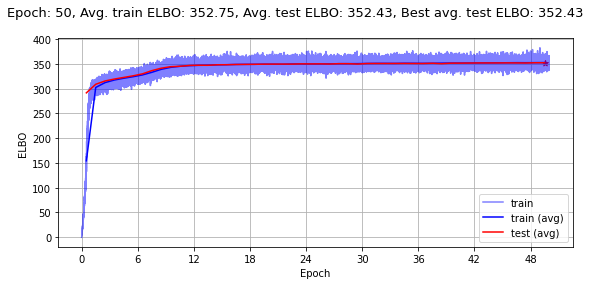

In [30]:
# Fit the VAE model
model_score_vr, optimizer_score_vr, out_score_vr, fig = fit_model(model_score_vr, optimizer_score_vr,
                                                                  train_data, args_score_vr,
                                                                  test_data=test_data)

#### Snapshot

If you would like to save the trained model, uncomment the below. We have also provided code to load the saved model from a file (see the Jupyter cell before training).
See PyTorch documentation on [saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) models for more details.

In [31]:
# save_state(model_score_vr, optimizer_score_vr, 'VAE_score_vr.pt')

You can load a pre-trained model by uncommenting the below line.

In [29]:
# Alternatively to training a model from scratch you can load a pre-trained model
# load_state(model_score_vr, optimizer_score_vr, 'VAE_score_vr.pt')

#### Compare the estimators

We now plot the learning curve using the variance-reduced score function estimator on top of the previous comparison plot. Notice that the performance of the method has improved at negligible additional computational expense. However, the performance gap is significant, in the following optional section we suggest increasing the number of samples in the Monte Carlo averaging to further improve the performance of the method at an additional computational cost.

Text(0.5, 0, 'Epoch')

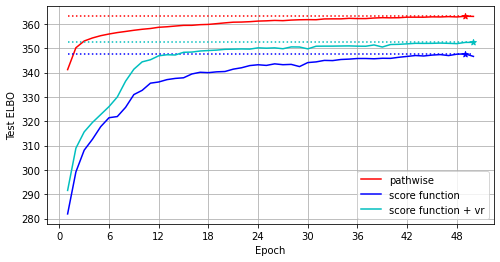

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(out_path['test_avg_epochs'], out_path['test_avg_elbos'], 
        color='r', label='pathwise')
amax = np.argmax(out_path['test_avg_elbos'])
ax.hlines(out_path['test_avg_elbos'][amax], 
          np.min(out_path['test_avg_epochs']), np.max(out_path['test_avg_epochs']),
         color='r', linestyles='dotted')
ax.scatter(out_path['test_avg_epochs'][amax], out_path['test_avg_elbos'][amax], color='r', marker='*')

ax.plot(out_score['test_avg_epochs'], out_score['test_avg_elbos'], 
        color='b', label='score function')
amax = np.argmax(out_score['test_avg_elbos'])
ax.hlines(out_score['test_avg_elbos'][amax], 
          np.min(out_score['test_avg_epochs']), np.max(out_score['test_avg_epochs']),
         color='b', linestyles='dotted')
ax.scatter(out_score['test_avg_epochs'][amax], out_score['test_avg_elbos'][amax], color='b', marker='*')

ax.plot(np.array(out_score_vr['test_avg_epochs']), out_score_vr['test_avg_elbos'], 
        color='c', label='score function + vr')
amax = np.argmax(out_score_vr['test_avg_elbos'])
ax.hlines(out_score_vr['test_avg_elbos'][amax], 
          np.min(out_score_vr['test_avg_epochs']), np.max(out_score_vr['test_avg_epochs']),
         color='c', linestyles='dotted')
ax.scatter(out_score_vr['test_avg_epochs'][amax], out_score_vr['test_avg_elbos'][amax], color='c', marker='*')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.grid(True)
ax.legend(loc='lower right')
ax.set_ylabel('Test ELBO')
ax.set_xlabel('Epoch')

### Fit VAE with score function + VR + more Monte Carlo averaging  (optional, not examinable)

We can further improve the method's performance by increasing Monte Carlo averaging in the expectation. However, note that this can significantly increase the computational cost of the method. 

We still use the same architecture and hyperparameters as before. Except we use 100 Monte Carlo samples to approximate the expectation and with the larger Monte Carlo averaging and variance reduction we can use a higher learning rate of 0.0007 in Adam. 

Note that if you have changed the dimensionality of the data from the default 14x14 in [MNIST section](#MNIST), then the optimal values will change (on 28x28 data try using $c=1400$, and on 10x10 data try using $c=100$).

Also note that running the below will take significantly longer than the previous experiments, hence it is optional. We expect that running the below should not take more than a couple of hours.

In [33]:
# Specify the hyperpameter choices
data_dim = train_data[0][0].numel()
args_score_vr_mc100 = ['--dec_layer_dims', '2', '100', f'{data_dim}',
                       '--enc_layer_dims', f'{data_dim}', '100', '2',
                       '--gradient_type', 'score',
                       '--num_variational_samples', '100',
                       '--epochs', '50',
                       '--learning_rate', '7e-4',
                       '--vr_coeff', '320',
                       '--cuda']

args_score_vr_mc100 = parser_vr.parse_args(args_score_vr_mc100)
args_score_vr_mc100.cuda = args_score_vr_mc100.cuda and torch.cuda.is_available()
args_score_vr_mc100.device = torch.device("cuda" if args_score_vr_mc100.cuda else "cpu")

# Seed all random number generators for reproducibility of the runs
seed_everything(args_score_vr_mc100.seed)

# Initialise the model and the Adam (SGD) optimiser
model_score_vr_mc100 = VAEwScoreVR(args_score_vr_mc100).to(args_score_vr_mc100.device)
optimizer_score_vr_mc100 = optim.Adam(model_score_vr_mc100.parameters(), lr=args_score_vr_mc100.learning_rate)

The below experiment should not take longer than 2 hours. Remember, this experiment is optional! After the first epoch is finished, the progress bar below will show the estimated time left.

If you do not wish to train the model yourself you can comment the following cell and uncomment the cell with `load_state(...)` code below.

Test Epoch: 50 [9950/10000 (100%)] ELBO: 366.417816: 100%|█| 50/50 [30:


Loading best model state from epoch 47.
Loading best optimizer state from epoch 47.


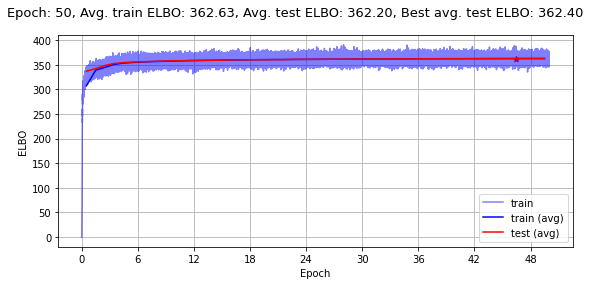

In [35]:
# Fit the VAE model, should take no longer than 2-3 hours
model_score_vr_mc100, optimizer_score_vr_mc100, out_score_vr_mc100, fig = \
    fit_model(model_score_vr_mc100, optimizer_score_vr_mc100,
              train_data, args_score_vr_mc100,
              test_data=test_data)

#### Snapshot

If you would like to save the trained model, uncomment the below. We have also provided code to load the saved model from a file (see the Jupyter cell before training).
See PyTorch documentation on [saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) models for more details.

In [36]:
# save_state(model_score_vr_mc100, optimizer_score_vr_mc100, 'VAE_score_vr_mc100.pt')

You can load a pre-trained model by uncommenting the below line.

In [34]:
# Alternatively to training a model from scratch you can load a pre-trained model
# load_state(model_score_vr_mc100, optimizer_score_vr_mc100, 'VAE_score_vr_mc100.pt')

#### Compare the estimators

At an additional computational cost the score function estimator is able to get closer in performance to the pathwise estimator.  However, you might wonder which of the two changes had a higher effect: the introduction of a control variate, or the larger Monte Carlo averaging. In the next section we suggest running the score function experiment with larger Monte Carlo but without the control variate variance reduction.

Text(0.5, 0, 'Epoch')

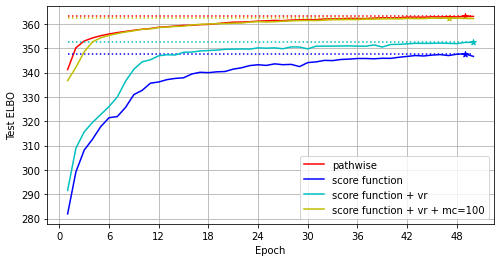

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(out_path['test_avg_epochs'], out_path['test_avg_elbos'], 
        color='r', label='pathwise')
amax = np.argmax(out_path['test_avg_elbos'])
ax.hlines(out_path['test_avg_elbos'][amax], 
          np.min(out_path['test_avg_epochs']), np.max(out_path['test_avg_epochs']),
         color='r', linestyles='dotted')
ax.scatter(out_path['test_avg_epochs'][amax], out_path['test_avg_elbos'][amax], color='r', marker='*')

ax.plot(out_score['test_avg_epochs'], out_score['test_avg_elbos'], 
        color='b', label='score function')
amax = np.argmax(out_score['test_avg_elbos'])
ax.hlines(out_score['test_avg_elbos'][amax], 
          np.min(out_score['test_avg_epochs']), np.max(out_score['test_avg_epochs']),
         color='b', linestyles='dotted')
ax.scatter(out_score['test_avg_epochs'][amax], out_score['test_avg_elbos'][amax], color='b', marker='*')

ax.plot(np.array(out_score_vr['test_avg_epochs']), out_score_vr['test_avg_elbos'], 
        color='c', label='score function + vr')
amax = np.argmax(out_score_vr['test_avg_elbos'])
ax.hlines(out_score_vr['test_avg_elbos'][amax], 
          np.min(out_score_vr['test_avg_epochs']), np.max(out_score_vr['test_avg_epochs']),
         color='c', linestyles='dotted')
ax.scatter(out_score_vr['test_avg_epochs'][amax], out_score_vr['test_avg_elbos'][amax], color='c', marker='*')

ax.plot(np.array(out_score_vr_mc100['test_avg_epochs']), out_score_vr_mc100['test_avg_elbos'], 
        color='y', label='score function + vr + mc=100')
amax = np.argmax(out_score_vr_mc100['test_avg_elbos'])
ax.hlines(out_score_vr_mc100['test_avg_elbos'][amax], 
          np.min(out_score_vr_mc100['test_avg_epochs']), np.max(out_score_vr_mc100['test_avg_epochs']),
         color='y', linestyles='dotted')
ax.scatter(out_score_vr_mc100['test_avg_epochs'][amax], out_score_vr_mc100['test_avg_elbos'][amax], 
           color='y', marker='*')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.grid(True)
ax.legend(loc='lower right')
ax.set_ylabel('Test ELBO')
ax.set_xlabel('Epoch')

### Fit VAE with score function + w/o VR + more Monte Carlo averaging  (optional, not examinable)

To make sure that variance reduction due to the control variates is the main source of the improvement of the score function estimator method, we suggest running the following code which runs a similar experiment as above but without the variance reduction via control variates.

Note that running the below will take significantly longer than the previous experiments, hence it is optional. We expect that running the below should not take more than a couple of hours.

Again, we had to reduce the learning rate to 0.0001, due to the observed higher gradient variance when not using the control covariates.

In [38]:
# Specify the hyperpameter choices
data_dim = train_data[0][0].numel()
args_score_mc100 = ['--dec_layer_dims', '2', '100', f'{data_dim}',
                       '--enc_layer_dims', f'{data_dim}', '100', '2',
                       '--gradient_type', 'score',
                       '--num_variational_samples', '100',
                       '--epochs', '50',
                       '--learning_rate', '1e-4',
                       '--cuda']

args_score_mc100 = parser_vr.parse_args(args_score_mc100)
args_score_mc100.cuda = args_score_mc100.cuda and torch.cuda.is_available()
args_score_mc100.device = torch.device("cuda" if args_score_mc100.cuda else "cpu")

# Seed all random number generators for reproducibility of the runs
seed_everything(args_score_mc100.seed)

# Initialise the model and the Adam (SGD) optimiser
model_score_mc100 = VAE(args_score_mc100).to(args_score_mc100.device)
optimizer_score_mc100 = optim.Adam(model_score_mc100.parameters(), lr=args_score_mc100.learning_rate)

The below experiment should not take longer than 2 hours. Remember, this experiment is optional! After the first epoch is finished, the progress bar below will show the estimated time left.

If you do not wish to train the model yourself you can comment the following cell and uncomment the cell with `load_state(...)` code below.

Test Epoch: 50 [9950/10000 (100%)] ELBO: 356.318054: 100%|█| 50/50 [31:


Loading best model state from epoch 49.
Loading best optimizer state from epoch 49.


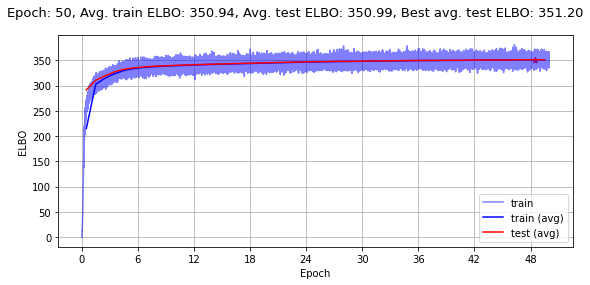

In [40]:
# Fit the VAE model, should take no longer than 2-3 hours
model_score_mc100, optimizer_score_mc100, out_score_mc100, fig = \
    fit_model(model_score_mc100, optimizer_score_mc100,
              train_data, args_score_mc100,
              test_data=test_data)


#### Snapshot

If you would like to save the trained model, uncomment the below. We have also provided code to load the saved model from a file (see the Jupyter cell before training).
See PyTorch documentation on [saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) models for more details.

In [41]:
# save_state(model_score_mc100, optimizer_score_mc100, 'VAE_score_mc100.pt')

You can load a pre-trained model by uncommenting the below line.

In [39]:
# Alternatively to training a model from scratch you can load a pre-trained model
# load_state(model_score_mc100, optimizer_score_mc100, 'VAE_score_mc100.pt')

#### Compare estimators 

We now see that in fact the introduction of the control variates was crucial to the performance improvement of the score function estimator method.

Text(0.5, 0, 'Epoch')

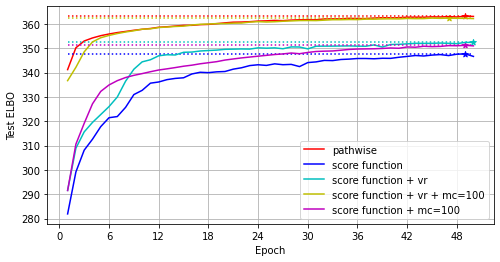

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(out_path['test_avg_epochs'], out_path['test_avg_elbos'], 
        color='r', label='pathwise')
amax = np.argmax(out_path['test_avg_elbos'])
ax.hlines(out_path['test_avg_elbos'][amax], 
          np.min(out_path['test_avg_epochs']), np.max(out_path['test_avg_epochs']),
         color='r', linestyles='dotted')
ax.scatter(out_path['test_avg_epochs'][amax], out_path['test_avg_elbos'][amax], color='r', marker='*')

ax.plot(out_score['test_avg_epochs'], out_score['test_avg_elbos'], 
        color='b', label='score function')
amax = np.argmax(out_score['test_avg_elbos'])
ax.hlines(out_score['test_avg_elbos'][amax], 
          np.min(out_score['test_avg_epochs']), np.max(out_score['test_avg_epochs']),
         color='b', linestyles='dotted')
ax.scatter(out_score['test_avg_epochs'][amax], out_score['test_avg_elbos'][amax], color='b', marker='*')

ax.plot(np.array(out_score_vr['test_avg_epochs']), out_score_vr['test_avg_elbos'], 
        color='c', label='score function + vr')
amax = np.argmax(out_score_vr['test_avg_elbos'])
ax.hlines(out_score_vr['test_avg_elbos'][amax], 
          np.min(out_score_vr['test_avg_epochs']), np.max(out_score_vr['test_avg_epochs']),
         color='c', linestyles='dotted')
ax.scatter(out_score_vr['test_avg_epochs'][amax], out_score_vr['test_avg_elbos'][amax], color='c', marker='*')

ax.plot(np.array(out_score_vr_mc100['test_avg_epochs']), out_score_vr_mc100['test_avg_elbos'], 
        color='y', label='score function + vr + mc=100')
amax = np.argmax(out_score_vr_mc100['test_avg_elbos'])
ax.hlines(out_score_vr_mc100['test_avg_elbos'][amax], 
          np.min(out_score_vr_mc100['test_avg_epochs']), np.max(out_score_vr_mc100['test_avg_epochs']),
         color='y', linestyles='dotted')
ax.scatter(out_score_vr_mc100['test_avg_epochs'][amax], out_score_vr_mc100['test_avg_elbos'][amax], 
           color='y', marker='*')

ax.plot(np.array(out_score_mc100['test_avg_epochs']), out_score_mc100['test_avg_elbos'], 
        color='m', label='score function + mc=100')
amax = np.argmax(out_score_mc100['test_avg_elbos'])
ax.hlines(out_score_mc100['test_avg_elbos'][amax], 
          np.min(out_score_mc100['test_avg_epochs']), np.max(out_score_mc100['test_avg_epochs']),
         color='m', linestyles='dotted')
ax.scatter(out_score_mc100['test_avg_epochs'][amax], out_score_mc100['test_avg_elbos'][amax], 
           color='m', marker='*')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.grid(True)
ax.legend(loc='lower right')
ax.set_ylabel('Test ELBO')
ax.set_xlabel('Epoch')

## Discussion on fitting with pathwise and score function gradient estimators (optional, not examinable)

From the above experiments you should clearly see that the pathwise gradient estimator has a computational advantage for fitting the specified VAE model over the score function estimator. This aligns with many empirical observations in the VAE literature and has motivated a significant amount of research on generalising the pathwise gradient estimator to more distribution families, such as the [implicit reparametrisation gradients](https://arxiv.org/abs/1805.08498). 

Nevertheless, the score function gradient estimator remains a more general method, which enables the fitting of discrete variational distributions or other distributions where pathwise gradients are not available. For example, VAEs with discrete latent variables have been shown to have a surprising capacity to fit [image and natural language data](https://arxiv.org/abs/1711.00937) very well, and have been demonstrated to recover discrete natural phenomena, such as phonemes in a language (distinct sounds in a specific language), when fitted on speech data.
Moreover, discrete variational distributions could be useful for fitting discrete statistical models from incomplete data, where a variational distribution could be specified over the discrete missing variables.

We have also shown above that control variates and increased Monte Carlo averaging can be used to improve the performance of the score function estimator. 

## Sampling the fitted model

Since the VAE is modelling images, we can also assess the quality of the fit by inspecting the samples from the model. 

We can sample the VAE using ancestral sampling, where we first generate $\mathbf{z} \sim p(\mathbf{z})$ and then sample $\mathbf{x} \sim p_{\theta}(\mathbf{x} \mid \mathbf{z})$. We also visualise the expected value $\mathbb{E}_{p_{\theta}(\mathbf{x} \mid \mathbf{z})}(\mathbf{x})$ and the parameters $\eta = \text{sigmoid}(\mathbf{f}_{\theta}(\mathbf{z}))$ of the continuous Bernoulli distribution, which is common in the VAE literature with Bernoulli and Gaussian generative distributions.

We use the model trained with pathwise gradients `model_path`.

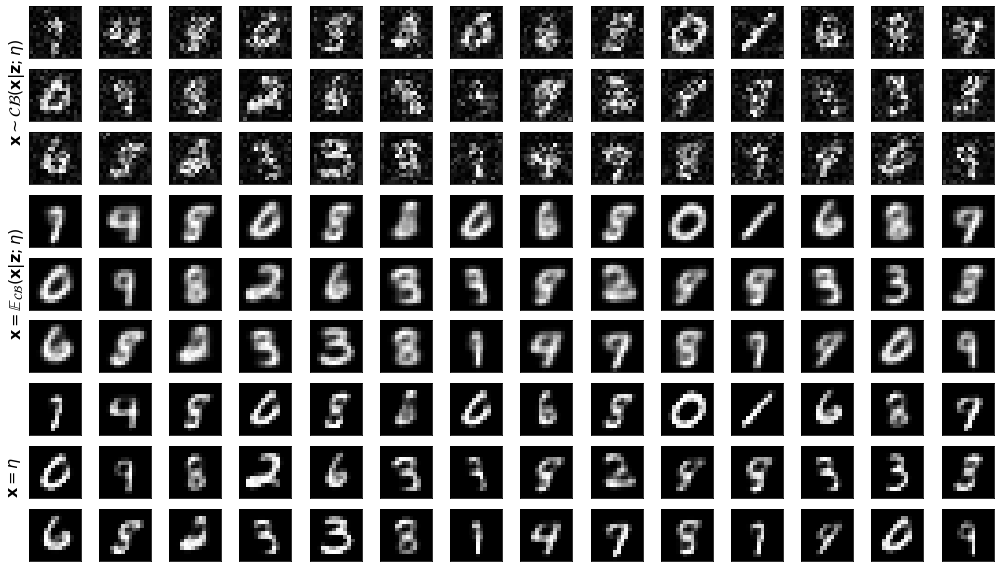

In [43]:
N = 42
Z = torch.randn(N, 2, device=args_path.device)
with torch.inference_mode():
    # Sample the latents
    logits = model_path.decoder(Z)
    
    # Use ancestral sampling to produce samples
    samples = model_path.decoder.sample(logits, num_samples=1).detach().cpu()[0]
    means = model_path.decoder.mean(logits).detach().cpu()
    params = model_path.decoder.param_p(logits).detach().cpu()

    # Create a matrix of samples
    X = torch.vstack([samples, means, params])
    X = X.view(-1, *data_dims).detach().cpu()

    # Create a figure
    fig = plot_grid_of_mnist_samples(X, grid=(9, 14), figsize=(14, 8))
    fig.text(0, 0.833, '$\mathbf{x} \sim \mathcal{CB}(\mathbf{x} | \mathbf{z}; \eta)$', 
             rotation='vertical', verticalalignment='center', fontsize=16)
    fig.text(0, 0.5, '$\mathbf{x} = \mathbb{E}_{\mathcal{CB}}(\mathbf{x} | \mathbf{z}; \eta)$',
             rotation='vertical', verticalalignment='center', fontsize=16)
    fig.text(0, 0.166, '$\mathbf{x} = \eta$',
             rotation='vertical', verticalalignment='center', fontsize=16)
    fig.tight_layout()

#### Exercise 8

1. Looking at the visualisations above explain the differences between the samples in the top three rows and the middle three rows. The figure 1 in the [continuous Bernoulli paper](https://arxiv.org/abs/1907.06845) might be useful to support your reasoning: (note that the parameters $\eta$ are denoted as $\lambda$ in the referenced paper)
![Continuous Bernoulli mean](./figures/CB-figure-1-mean.png)


2. It is known that using standard Bernoulli distribution on non-binary data in VAEs results in blurry image samples. However, as we see in the last three rows the images look sharper than the other visualisations. Explain why.  
To support your reasoning consider the difference between the variational lower-bounds using the continuous Bernoulli $\mathcal{L}_{\mathcal{CB}}$ and the standard Bernoulli $\mathcal{L}_{\mathcal{B}}$ distributions below
$$
\begin{align}
\mathcal{L}_{\mathcal{CB}}(\theta, \phi) &= \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\sum_{d=1}^D x_d \log \eta(\mathbf{z})_d + (1 - x_d) \log (1 - \eta(\mathbf{z})_d) + \log C\left(\eta(\mathbf{z})_d\right)\right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \middle|\middle| p(\mathbf{z})\right)\\
\mathcal{L}_{\mathcal{B}}(\theta, \phi) &= \mathbb{E}_{q_{\phi}(\mathbf{z} \mid \mathbf{x})}\left[\sum_{d=1}^D x_d \log \eta(\mathbf{z})_d + (1 - x_d) \log (1 - \eta(\mathbf{z})_d)\right] - \text{KL}\left(q_{\phi}(\mathbf{z} \mid \mathbf{x}) \middle|\middle| p(\mathbf{z})\right)
\end{align}
$$
Then, also use the below figure of the normalising constant $\log C$ from figure 1 of the paper to make your claim (note that the paper uses the following notation to define the normalised distribution $p = C \tilde{p}$ from the unnormalised density $\tilde{p}$)
![Continuous Bernoulli, log normalising constant](./figures/CB-figure-1-log-norm-const.png)

<details><summary><a>Answer (click)<a></summary>

1. We can see that the samples in the top row are noisy, and in particular, there are grey pixels all around the image---where the background should be black we see some grey noise and where the "ink" should be white we also see some grey noise. These grey pixels are due to the predicted parameters $\eta_d=\text{sigmoid}(f_{\theta}(\mathbf{z})_d)$ not being close enough to 0 (black) or 1 (white), hence sampling this distribution results in some grey pixels.
The source of this behaviour can be attributed to the unconstrained optimisation of $\eta_d$. 
The parameters $\eta_d$ are in the $(0, 1)$ range, where values closer to 0 result in sampling more darker pixels and closer to 1 result in more lighter pixels. However, to make the use of off-the-shelf gradient ascent optimisers easier, we actually optimise an unconstrained parameter $l_d = \text{logit}(\eta_d) = f_{\theta}(\mathbf{z})_d$ (see logit function [here](https://en.wikipedia.org/wiki/Logit)). Now to make $\eta_d$ close to 0 or 1, $l_d$ must approach $-\infty$ or $\infty$, respectively. However, neural networks are unlikely to predict such extreme values unless some numerical instability occurs, hence resulting in the image noise we observed.

 To understand the effect of the mean on the samples above, it is useful to see the parameter $\eta$ versus mean $\mu$ figure from the continuous Bernoulli paper (the 1st figure above).
You should note that for parameter values between 0.1 and 0.9 the mean function pushes the values towards 0.5, thus resulting in smoother, even blurry, samples as seen above.
The grey noise also vanishes as it is averaged out in the expectation.  

2. In the final two rows we plot the parameter values $\eta=\text{sigmoid}(\mathbf{f}_{\theta}(\mathbf{z}))$ of the continuous Bernoulli distribution. It is a common observation that plotting the parameters of the distribution using the standard Bernoulli distribution on non-binary data in VAEs results in blurry images. The authors of the [continuous Bernoulli](https://arxiv.org/abs/1907.06845) have demonstrated that this effect is due to the standard Bernoulli distribution ignoring the log normalising constant $\log C(\eta)$ in the likelihood function (see 2nd figure above), which arises due to the use of the real domain in $[0, 1]$. The log normalising constant $\log C(\eta)$ acts as a regulariser that encourages the parameters to be more extreme (0 or 1) and discourages values close to 0.5, hence resulting in the sharpening of the samples compared to the standard Bernoulli distribution, which ignores the constant.

</details>

## Inspecting the latent space (optional, not examinable)

In the above exercises you have fitted a VAE with 2-dimensional latent space to the MNIST data in an [unsupervised](https://en.wikipedia.org/wiki/Unsupervised_learning) manner---the labels, which denote the digit in the image, were not used during training.
As we saw in the previous section, the generative model $p_{\theta}(\mathbf{x}\mid \mathbf{z})$ is capable of generating all digits in the training dataset, whilst using a single amortised neural network.
Hence, intuitively, there should be some structure in the latent space amongst the different categories to facilitate easier generation.
This intuition has motivated research on [feature disentanglement using VAEs](https://openreview.net/forum?id=Sy2fzU9gl) and [identifiable VAEs](https://arxiv.org/abs/1907.04809).

Below we provide the code to visualise the latent space of the VAE. You should observe that images representing the same digit should be co-located in the latent space, but also you might notice that "similar" numbers may as well be close.


With a Gaussian variational distribution, it is common to use the mean of the variational distribution $\mathbb{E}_{q_{\phi}(\mathbf{z}\mid \mathbf{x})}\left[ \mathbf{z} \right]$ to project the high-dimensional observed data-points to lower dimensional representations. The following code uses the model trained with pathwise gradients to project the test MNIST data to the low-dimensional space.

In [44]:
with torch.inference_mode():
    model_path.eval()
    model_path = model_path.to(args_path.device)
    
    test_loader = create_dataloader(test_data, args_path)
    
    Z = []
    Y = []
    for batch_idx, (X, labels) in tqdm(enumerate(test_loader)):
        # Prepare
        X = X.to(args_path.device)
        X = X.view([-1] + [X.shape[-2]*X.shape[-1]])
        
        # Project
        mean, _ = model_path.encoder(X)
        
        # Collect
        Z.append(mean)
        Y.append(labels)
        
    Z = torch.vstack(Z)
    Y = torch.hstack(Y)
    

200it [00:00, 307.64it/s]


We now visualise the projected images `Z` in 2-dimensions and color each point with a color corresponding to its label.

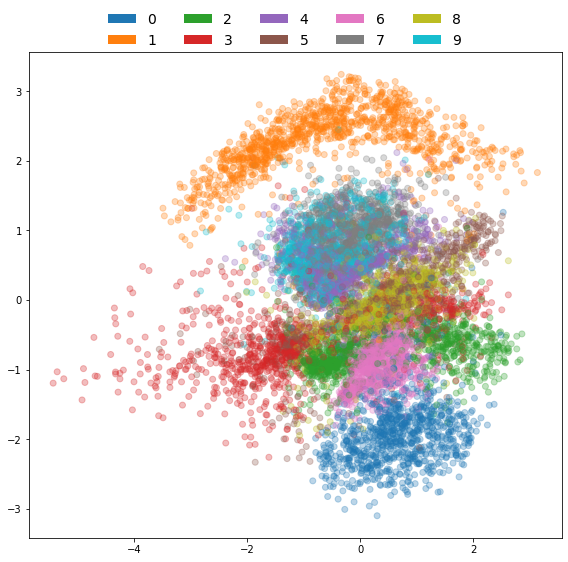

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

# Transfer tensors back to cpu
Z = Z.cpu()
Y = Y.cpu()

# Plot all samples in a specific color dependent on the label
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
c = np.array(colors)[Y.numpy()]
ax.scatter(Z[:, 0], Z[:, 1], color=c, alpha=0.3)

# Create legend
legend_elements = [mpl.patches.Patch(facecolor=colors[i], label=i) for i in range(10)]
ax.legend(handles=legend_elements, ncol=5,
          bbox_to_anchor=(0.5, 0.93),
          bbox_transform=fig.transFigure,
          loc='center',
          prop={'size': 14},
          frameon=False)

fig.tight_layout()

As expected, you should observe that the images corresponding to the same digit should be close in the latent space. Moreover, you may also notice that visually similar handwritten digits may also be located close to each other, such as 4 and 9.

It is important to note that general VAEs are not identifiable, and hence the results may differ on different runs (for example, if ran the fitting on a different machine, or used an alternative random seed).

Alternatively, we also investigate the generator $p_{\theta}(\mathbf{x}\mid \mathbf{z})$ by showing the generated expected values of the continuous Bernoulli distribution $\mathbb{E}_{p_{\theta}(\mathbf{x}\mid \mathbf{z})}\left[\mathbf{x}\right]$ for a grid of latent variable values.

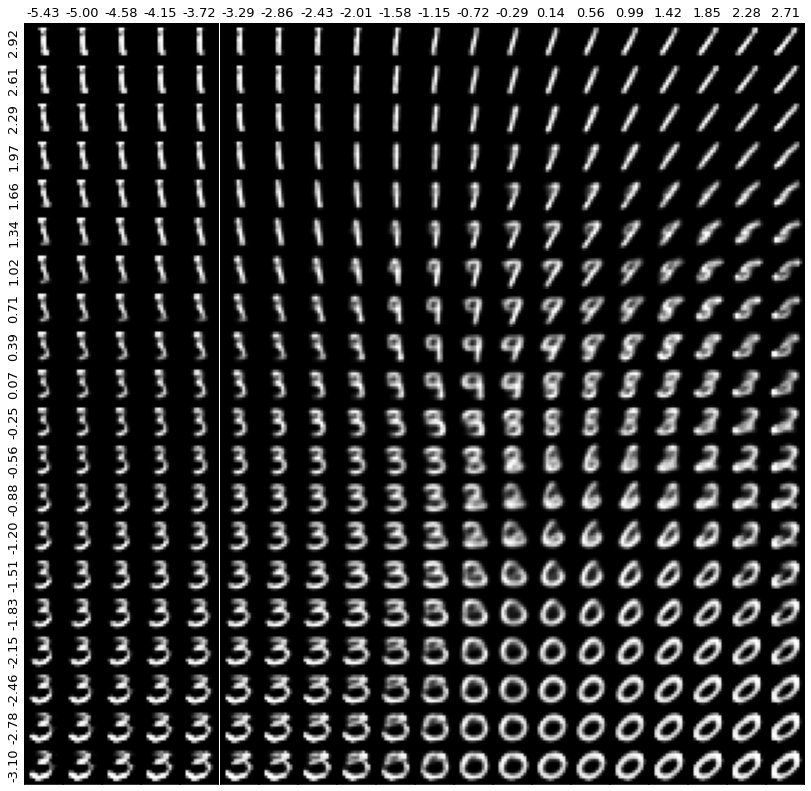

In [46]:
# Establish limits in the latent space
mx = Z.max(0)[0].cpu().numpy()
mn = Z.min(0)[0].cpu().numpy()

# Define the number of steps along each dimension
steps = 20
step_x = (mx[0]-mn[0])/steps
step_y = (mx[1]-mn[1])/steps

# Locations of the grid samples
x = np.arange(mn[0], mx[0], step_x)
y = np.arange(mn[1], mx[1], step_y)

# Create the tuples of latent locations
x0, x1 = np.mgrid[mn[0]:mx[0]:step_x, 
                  mn[1]:mx[1]:step_y]
Z_grid = np.empty(x0.shape + (2,))
Z_grid[:, :, 0] = x0
Z_grid[:, :, 1] = x1

with torch.inference_mode():
    # Predict the continuous Bernoulli means
    logits = model_path.decoder(torch.tensor(Z_grid, dtype=torch.float, device=args_path.device)).cpu()
    means = model_path.decoder.mean(logits).cpu().reshape(steps, steps, *data_dims)

    # Plot
    fig, axes = plt.subplots(steps, steps, sharex=True, sharey=True, figsize=(14, 14))
    fig.subplots_adjust(wspace=0., hspace=0.)
    for i, j in itertools.product(range(steps), range(steps)):
        axes[j, i].imshow(means[i, steps-j-1], cmap='gray')
        if j == 0:
            axes[j, i].set_title(f'{x[i]:.2f}', fontsize=13)
        if i == 0:
            axes[j, i].set_ylabel(f'{y[steps-j-1]:.2f}', fontsize=13)

        axes[j,i].tick_params(left=False, labelleft=False,
                              bottom=False, labelbottom=False)
    

You should see that the two visualisations should correspond with each other. In particular, similar areas in the latent space should correspond to similar numbers. 

However, since the variational distribution $q_{\phi}(\mathbf{z}\mid \mathbf{x})$ is only an approximation of the true posterior $p_{\theta}(\mathbf{z} \mid \mathbf{x})$, some disagreement between the two visualisations can be expected. Below we plot the two visualisations on top of each other, which may help to identify the disagreement.

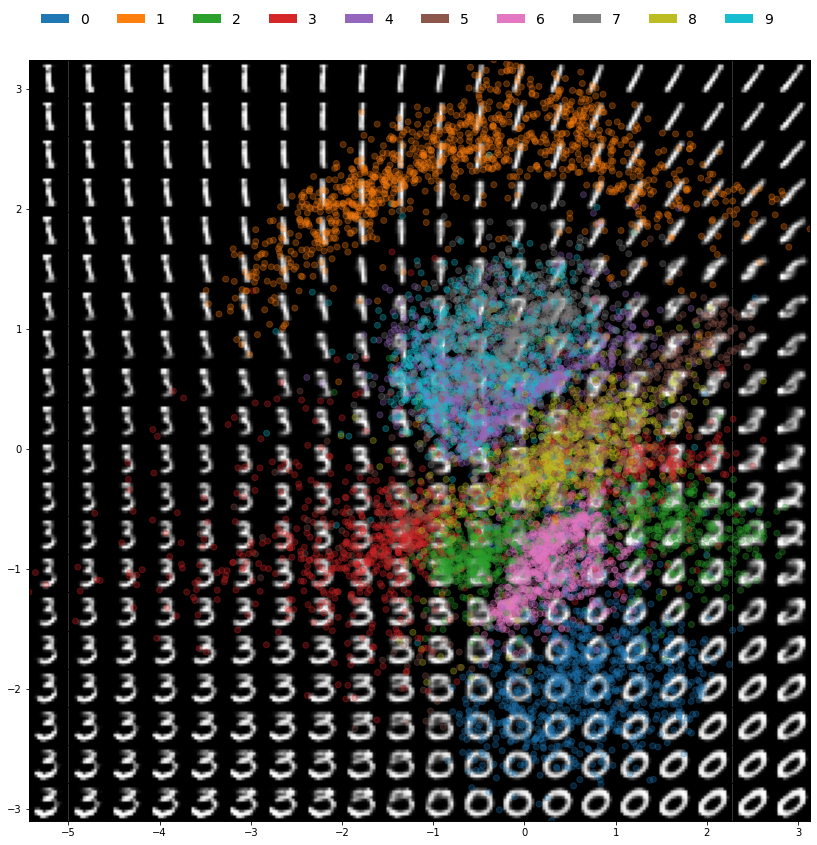

In [47]:
# Plot
fig, axes = plt.subplots(steps, steps, sharex=True, sharey=True, figsize=(14, 14))
fig.subplots_adjust(wspace=0., hspace=0.)

# Overlay another axes
rect = [axes[0][0].get_position().get_points()[0, 0], axes[-1][-1].get_position().get_points()[0, 1],
        axes[-1][-1].get_position().get_points()[1, 0]-axes[0][0].get_position().get_points()[0, 0],
        axes[0][0].get_position().get_points()[1, 1]-axes[-1][-1].get_position().get_points()[0, 1]
       ]
ax = fig.add_axes(rect)

# Plot samples
for i, j in itertools.product(range(steps), range(steps)):
    axes[j, i].imshow(means[i, steps-j-1], cmap='gray')
        
    axes[j,i].tick_params(left=False, labelleft=False,
                          bottom=False, labelbottom=False)

# Plot projections
ax.scatter(Z[:, 0], Z[:, 1], color=c, alpha=0.3)
ax.patch.set_alpha(0.)
ax.set_xlim(mn[0], mn[0]+step_x*steps)
ax.set_ylim(mn[1], mn[1]+step_y*steps)

# Create legend
legend_elements = [mpl.patches.Patch(facecolor=colors[i], label=i) for i in range(10)]
ax.legend(handles=legend_elements, ncol=10,
          bbox_to_anchor=(0.5, 0.92),
          bbox_transform=fig.transFigure,
          loc='center',
          prop={'size': 14},
          frameon=False)